In [1]:
# -*- coding: UTF-8 -*-
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
import tensorflow as tf
from os import path, remove
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import StratifiedShuffleSplit
from time import time
from matplotlib import pyplot as plt
import seaborn as sns
from mylibs.jupyter_notebook_helper import show_graph, renderStatsList, renderStatsCollection, \
    renderStatsListWithLabels, renderStatsCollectionOfCrossValids, plot_res_gp, my_plot_convergence
from tensorflow.contrib import rnn
from tensorflow.contrib import learn
import shutil
from tensorflow.contrib.learn.python.learn import learn_runner
from mylibs.tf_helper import getDefaultGPUconfig
from sklearn.metrics import r2_score
from mylibs.py_helper import factors
from fastdtw import fastdtw
from collections import OrderedDict
from scipy.spatial.distance import euclidean
from statsmodels.tsa.stattools import coint
from common import get_or_run_nn
from data_providers.data_provider_27_price_history_mobattrs_date import PriceHistoryMobAttrsDateDataProvider
from data_providers.price_history_dataset_generator import PriceHistoryDatasetGenerator
from skopt.space.space import Integer, Real
from skopt import gp_minimize
from skopt.plots import plot_convergence
import pickle
import inspect
import dill
import sys
from models.model_27_price_history_mobattrs_date import PriceHistoryMobAttrsDateModel
from gp_opt.price_history_27_gp_opt import PriceHistoryGpOpt

/home/studenthp/anaconda2/envs/dis/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
dtype = tf.float32
seed = 16011984
random_state = np.random.RandomState(seed=seed)
config = getDefaultGPUconfig()
n_jobs = 1
%matplotlib inline

### Step 0 - hyperparams

vocab_size is all the potential words you could have (classification for translation case)
and max sequence length are the SAME thing

decoder RNN hidden units are usually same size as encoder RNN hidden units in translation but for our case it does not seem really to be a relationship there but we can experiment and find out later, not a priority thing right now

In [4]:
input_len = 60
target_len = 30

batch_size = 300
with_EOS = False

In [5]:
full_train_size = 55820
train_size = 55800
small_train_size = 6000 #just because of performance reasons, no statistics behind this decision
test_size = 6200

### Once generate data

In [6]:
data_path = '../../../../Dropbox/data'

In [7]:
ph_data_path = data_path + '/price_history'

In [8]:
# npz_train_reduced = ph_data_path + '/price_history_mobattrs_date_dp_60to30_62020_6000_train.npz'
# npz_train = ph_data_path + '/price_history_mobattrs_date_dp_60to30_62020_train.npz'
# npz_test = ph_data_path + '/price_history_mobattrs_date_dp_60to30_62020_test.npz'

In [9]:
#npz_path = ph_data_path + '/price_history_mobattrs_date_dp_60to30_62020_6000'
npz_path = ph_data_path + '/price_history_mobattrs_date_dp_60to30_62020_trimmed'

In [10]:
npz_train = npz_path + '_train.npz'
assert path.isfile(npz_train)
path.abspath(npz_train)

'/home/studenthp/Dropbox/data/price_history/price_history_mobattrs_date_dp_60to30_62020_trimmed_train.npz'

In [11]:
# npz_train_full = ph_data_path + '/price_history_mobattrs_date_dp_60to30_62020_train.npz'
# npz_train_trimmed = ph_data_path + '/price_history_mobattrs_date_dp_60to30_62020_trimmed_train.npz'

In [12]:
# PriceHistoryDatasetGenerator.create_subsampled(inpath=npz_train_full, target_size=55800,
#                                                outpath=npz_train_trimmed, random_state=random_state)

### Step 1 - collect data

In [13]:
# dp = PriceHistoryMobAttrsDateDataProvider(npz_path=npz_path, batch_size=batch_size, with_EOS=with_EOS)
# for data in dp.datalist:
#     print data.shape

(55800, 60, 7)  
(55800, 139)  
(55800, 30)  
(55800, 30, 6)  

In [14]:
# for item in dp.next():
#     print item.shape

### Step 2 - Build model

In [15]:
model = PriceHistoryMobAttrsDateModel(rng=random_state, dtype=dtype, config=config, with_EOS=with_EOS)

In [16]:
# graph = model.getGraph(batch_size=batch_size,
#                        num_units = 10,
#                        rnn_hidden_dim = 10,
#                        mobile_attrs_dim = 10,
#                        input_len=input_len,
#                        target_len=target_len)

60
Tensor("inputs/unstack:0", shape=(100, 7), dtype=float32)

Tensor("encoder_rnn_layer/rnn/gru_cell_59/add:0", shape=(100, 10), dtype=float32)

time
Tensor("decoder_rnn_layer/rnn/while/add:0", shape=(), dtype=int32)

readout inputs
Tensor("decoder_rnn_layer/rnn/while/readout_input:0", shape=(100, 20), dtype=float32)

readout
Tensor("decoder_rnn_layer/rnn/while/readout:0", shape=(100, 1), dtype=float32)

decoder_final_loop_state
Tensor("decoder_rnn_layer/rnn/while/Exit_5:0", shape=(100, 30), dtype=float32)

Tensor("error/SquaredDifference:0", shape=(100, 30), dtype=float32)

Tensor("error/Mean:0", shape=(), dtype=float32)
Tensor("error/Mean:0", shape=(), dtype=float32)

In [17]:
#show_graph(graph)

## Quick test run

In [18]:
# def experiment():
#     return model.run(npz_path=ph_data_path + '/price_history_mobattrs_date_dp_60to30_62020_trimmed',
#                      rnn_hidden_dim = 300, #lets say worst case scenario
#                      mobile_attrs_dim = 300, #lets say worst case scenario
#                      epochs=2,
#                      batch_size = batch_size,
#                      enc_num_units = 600, #lets say worst case scenario
#                      dec_num_units = 600, #lets say worst case scenario
#                      input_len=input_len,
#                      target_len=target_len,
#                      learning_rate = 1e-2,
#                      preds_gather_enabled = False,
#                      decoder_first_input = PriceHistoryMobAttrsDateModel.DECODER_FIRST_INPUT.ZEROS,
#                     )
# aa = experiment()

keep_prob_rnn_out: 1.0  
lamda2: [0.0, 0.0, 0.0]  
learning_rate: 0.01  
enc_num_units: 600  
epochs: 2  
dec_num_units: 600  
keep_prob_readout: 1.0  
End Epoch 01 (453.036 secs): err(train) = 0.095174, current dec_ins_percent_usage: 1.00  
End Epoch 02 (460.136 secs): err(train) = 0.008046, current dec_ins_percent_usage: 0.00

### Step 3 training the network

In [19]:
model = PriceHistoryMobAttrsDateModel(rng=random_state, dtype=dtype, config=config, with_EOS=with_EOS)

In [20]:
if 'opt_res' in locals():
    print "defined above"
    best_params = opt_res.best_params
else:
    print "hardcoded"
    best_params = [415, 1.0, 1.0, 0.01, 168, 182, 1.0, 1.0000000000000001e-05, 1.0]

hardcoded


In [21]:
num_units, keep_prob_rnn_out, keep_prob_readout, learning_rate, rnn_hidden_dim, mobile_attrs_dim = [
    415, 0.8, 0.8, 1e0, 168, 182 ]
#best_params[:-PriceHistoryGpOpt.LAMDA2_COUNT]

In [22]:
lamda2_list = [1e-2, 1e-2, 1e-2] #best_params[-PriceHistoryGpOpt.LAMDA2_COUNT:]

In [23]:
batch_size

300

In [24]:
npz_test = npz_path[:-len('_trimmed')] + '_test.npz'
assert path.isfile(npz_test)
path.abspath(npz_test)

'/home/studenthp/Dropbox/data/price_history/price_history_mobattrs_date_dp_60to30_62020_test.npz'

In [25]:
# npz_test_trimmed = npz_test[:-len('_test.npz')] + '_trimmed' + '_test.npz'
# npz_test_trimmed
# PriceHistoryDatasetGenerator.create_subsampled(inpath=npz_test, target_size=6000,
#     outpath=npz_test_trimmed, random_state=random_state)

In [26]:
def experiment():
    return model.train_predict(npz_path=npz_path,
             epochs=100,
             batch_size = batch_size,
             num_units=num_units,
             input_len=input_len,
             target_len=target_len,
             learning_rate = learning_rate,
             decoder_first_input = PriceHistoryMobAttrsDateModel.DECODER_FIRST_INPUT.ZEROS,
             keep_prob_rnn_out=keep_prob_rnn_out,
             keep_prob_readout=keep_prob_readout,
             rnn_hidden_dim = rnn_hidden_dim,
             mobile_attrs_dim = mobile_attrs_dim,
             lamda2 = lamda2_list,
             plotting = True,
             dec_inputs_part = 5,
             cost_func = PriceHistoryMobAttrsDateModel.COST_FUNCS.HUBER_LOSS,
            )

keep_prob_rnn_out: 0.8
lamda2: [0.01, 0.01, 0.01]
learning_rate: 1.0
enc_num_units: 415
epochs: 100
dec_num_units: 415
keep_prob_readout: 0.8
End Epoch 01 (206.348 secs): err(train) = 15.562048, current dec_ins_percent_usage: 1.00
cur dtw score: 2936.29957925


/home/studenthp/anaconda2/envs/dis/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


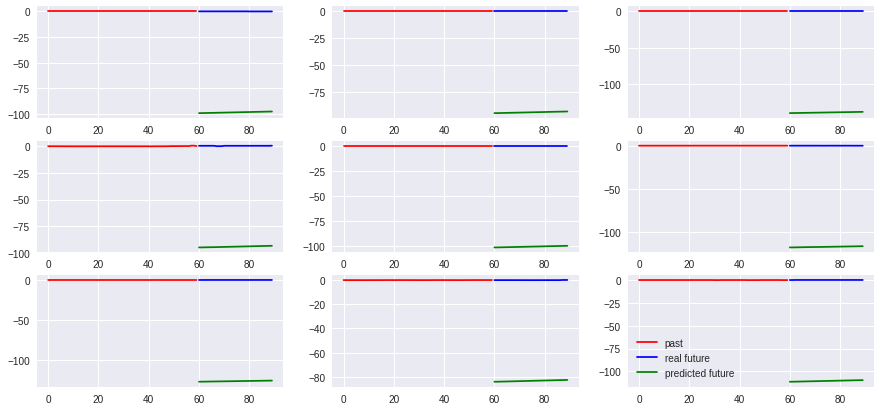

End Epoch 02 (204.021 secs): err(train) = 4.852672, current dec_ins_percent_usage: 0.75
cur dtw score: 3243.26931523


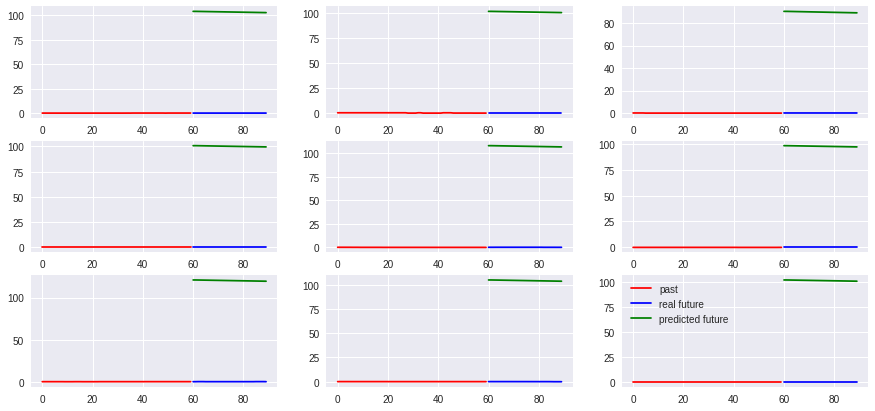

End Epoch 03 (204.048 secs): err(train) = 5.129243, current dec_ins_percent_usage: 0.50
cur dtw score: 239.749191081


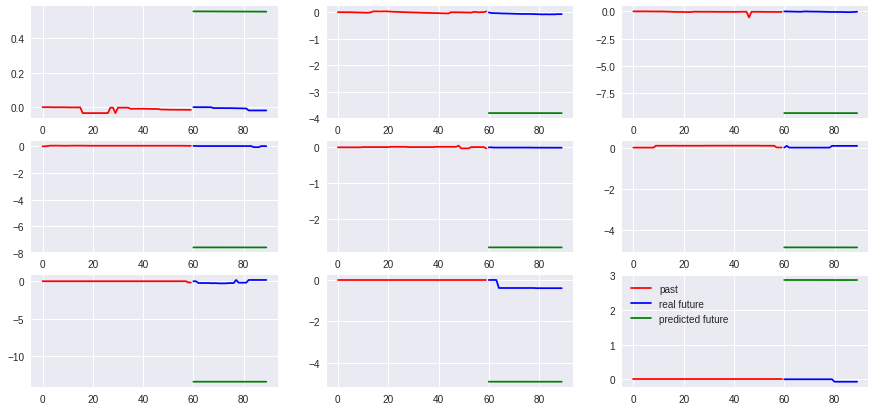

End Epoch 04 (204.151 secs): err(train) = 5.775129, current dec_ins_percent_usage: 0.25
cur dtw score: 948.062510181


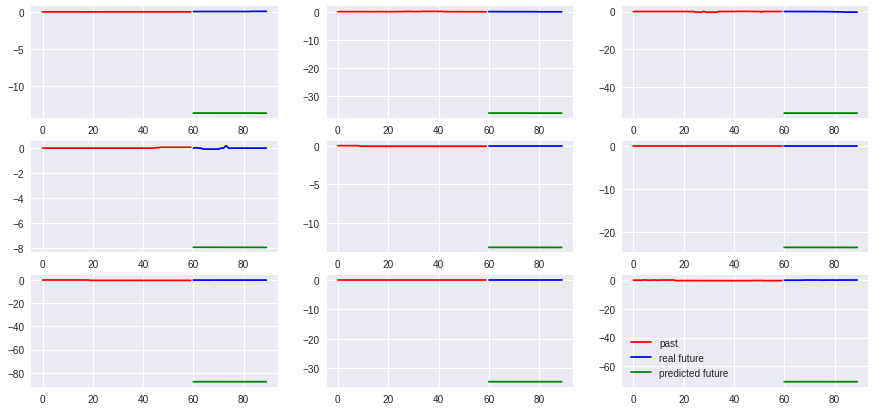

End Epoch 05 (203.910 secs): err(train) = 11.580898, current dec_ins_percent_usage: 0.00
cur dtw score: 1995.88407926


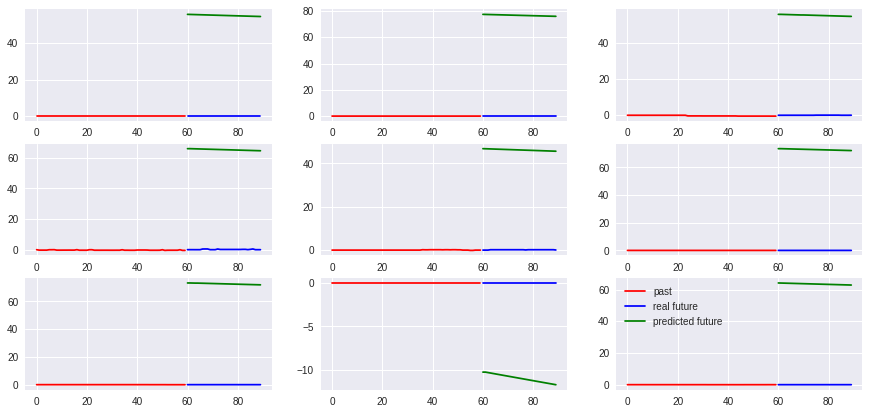

End Epoch 06 (204.087 secs): err(train) = 17.034867, current dec_ins_percent_usage: 0.00
cur dtw score: 310.58230076


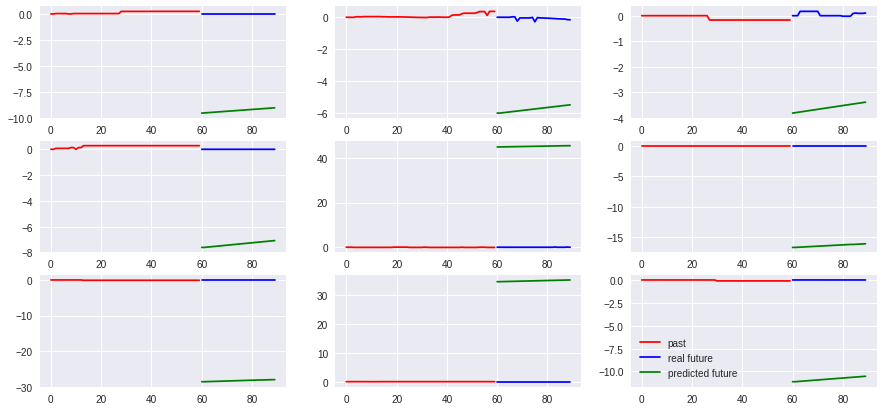

End Epoch 07 (204.107 secs): err(train) = 10.311002, current dec_ins_percent_usage: 0.00
cur dtw score: 740.42774795


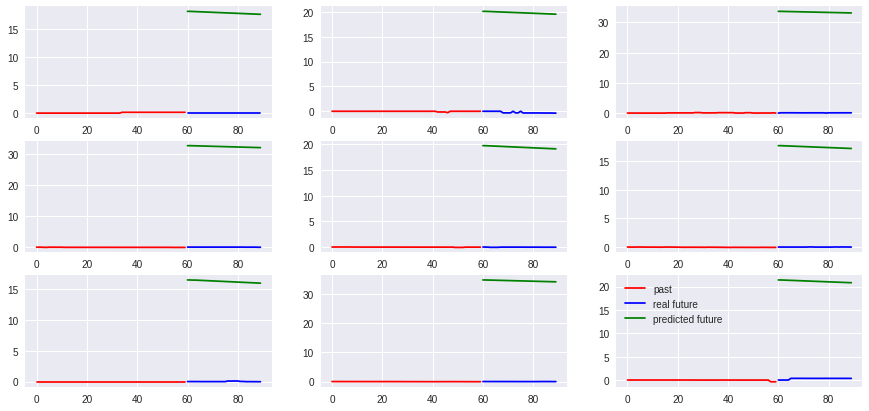

End Epoch 08 (204.012 secs): err(train) = 10.838464, current dec_ins_percent_usage: 0.00
cur dtw score: 195.254621984


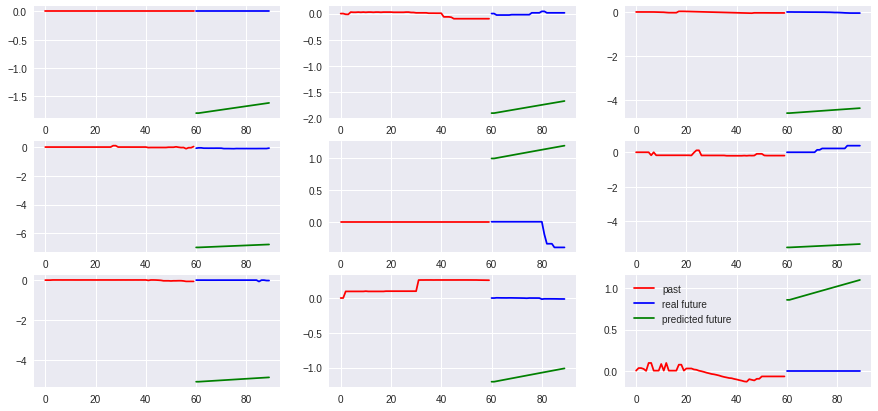

End Epoch 09 (204.058 secs): err(train) = 9.298327, current dec_ins_percent_usage: 0.00
cur dtw score: 2804.14287689


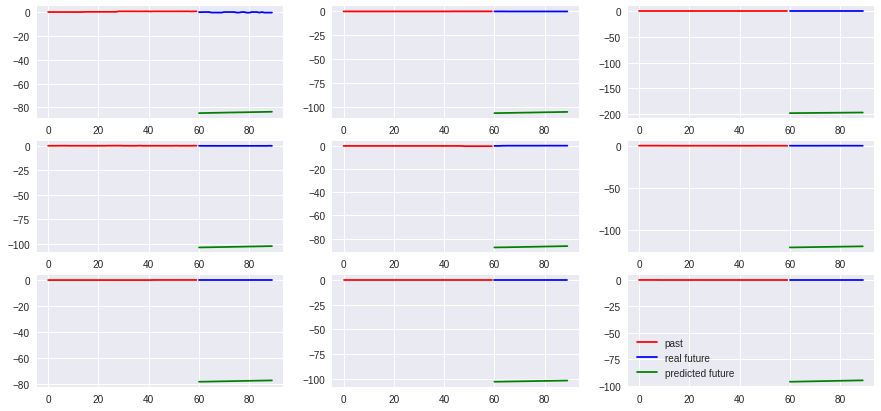

End Epoch 10 (204.023 secs): err(train) = 10.388584, current dec_ins_percent_usage: 0.00
cur dtw score: 831.890145976


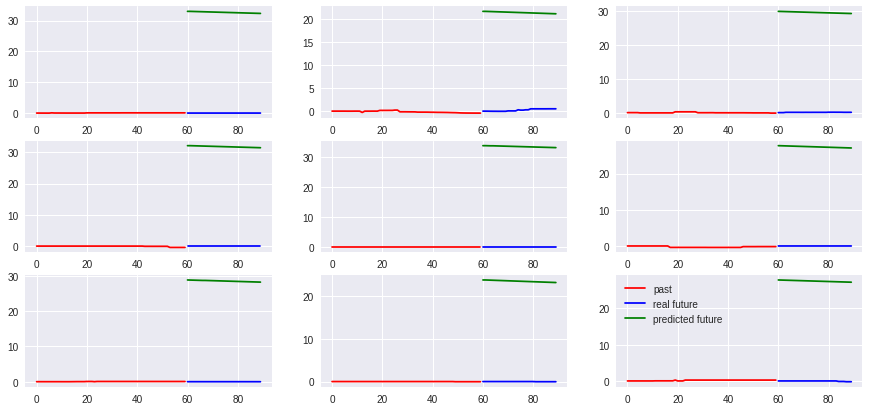

End Epoch 11 (204.031 secs): err(train) = 10.969656, current dec_ins_percent_usage: 0.00
cur dtw score: 8394.1977877


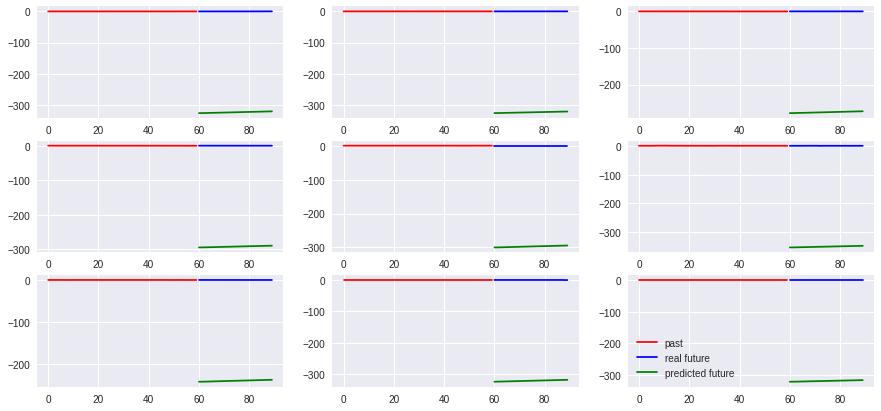

End Epoch 12 (204.032 secs): err(train) = 20.776606, current dec_ins_percent_usage: 0.00
cur dtw score: 516.45452726


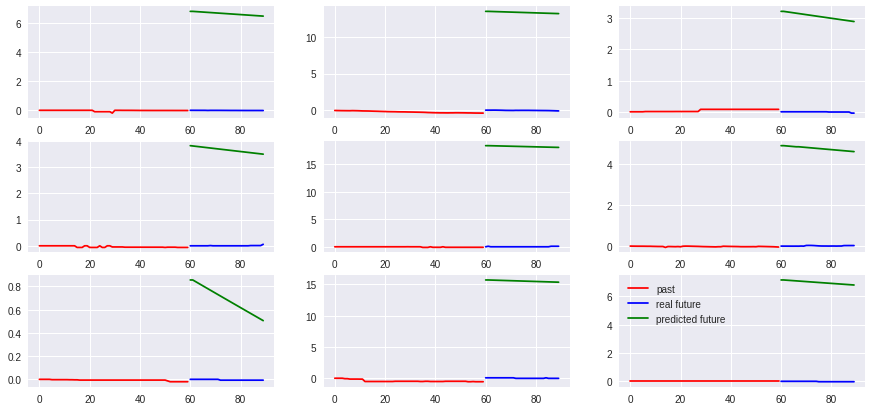

End Epoch 13 (204.023 secs): err(train) = 14.699799, current dec_ins_percent_usage: 0.00
cur dtw score: 868.680864458


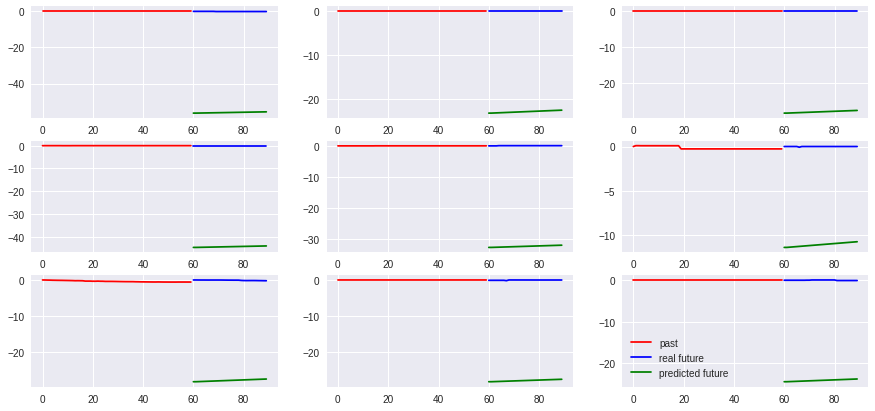

End Epoch 14 (203.986 secs): err(train) = 12.047925, current dec_ins_percent_usage: 0.00
cur dtw score: 606.594293159


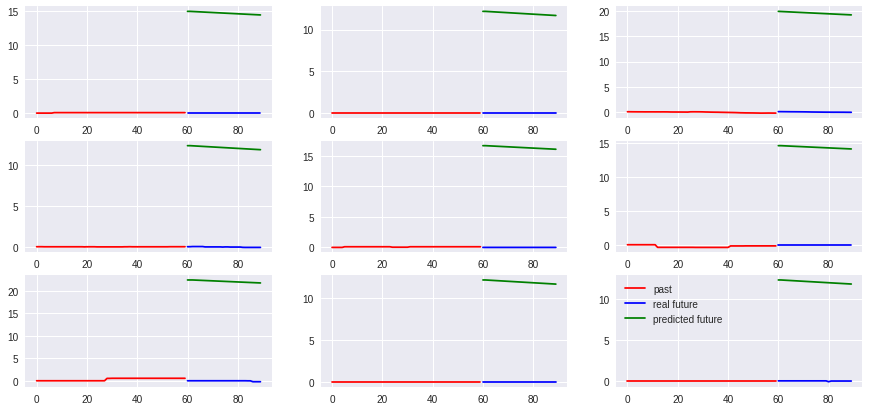

End Epoch 15 (203.876 secs): err(train) = 10.970954, current dec_ins_percent_usage: 0.00
cur dtw score: 201.170176985


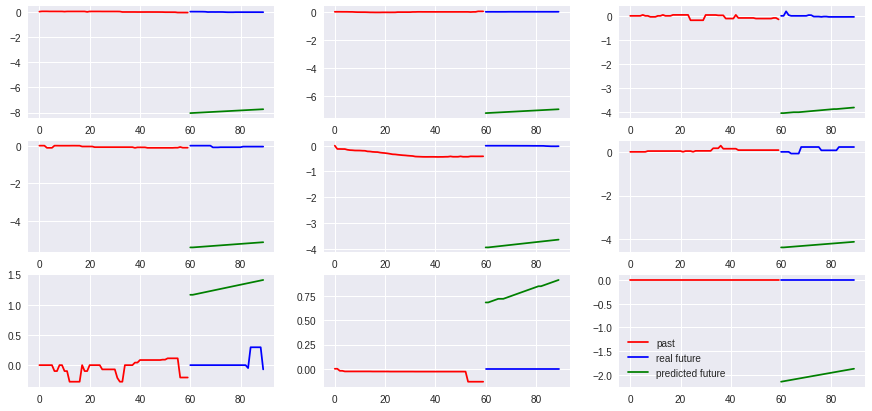

End Epoch 16 (204.037 secs): err(train) = 10.446977, current dec_ins_percent_usage: 0.00
cur dtw score: 1710.84860017


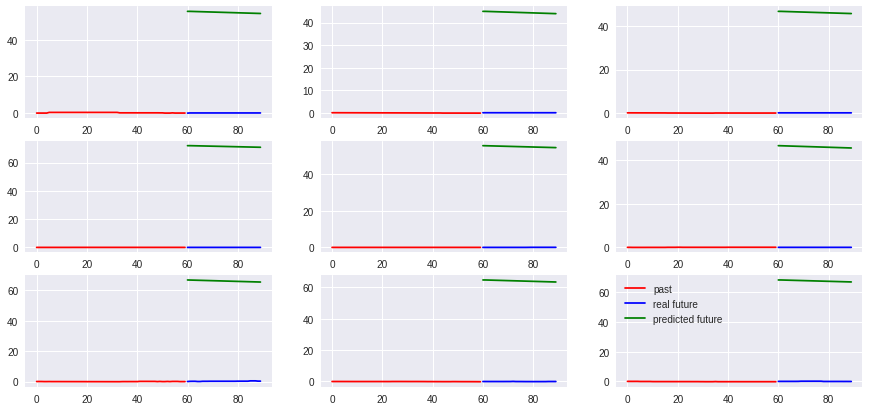

End Epoch 17 (204.148 secs): err(train) = 10.761298, current dec_ins_percent_usage: 0.00
cur dtw score: 424.358265691


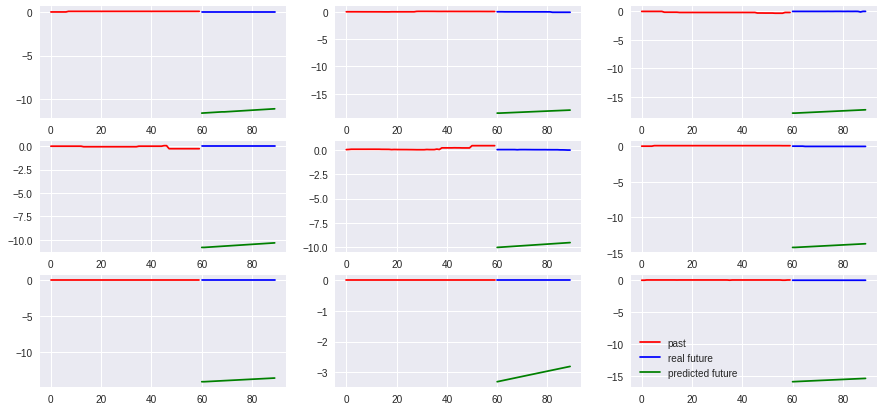

End Epoch 18 (203.921 secs): err(train) = 10.894551, current dec_ins_percent_usage: 0.00
cur dtw score: 1197.83750562


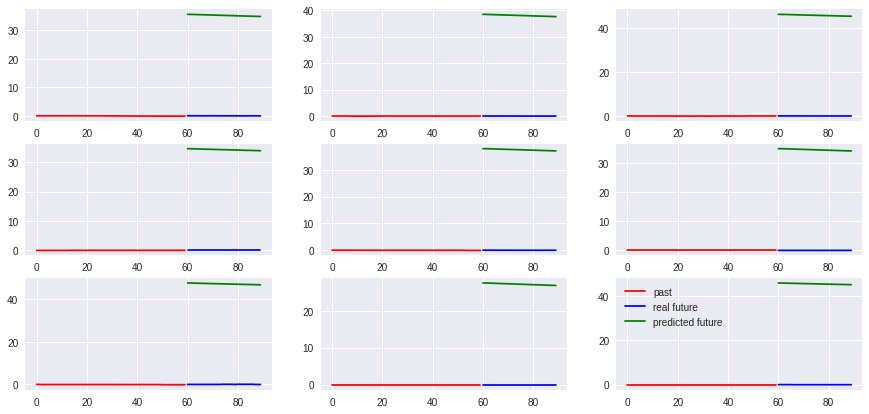

End Epoch 19 (204.032 secs): err(train) = 11.005040, current dec_ins_percent_usage: 0.00
cur dtw score: 2054.66385411


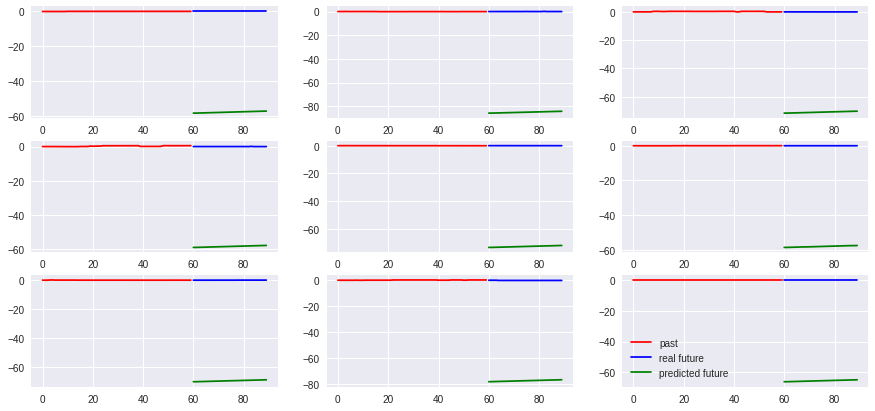

End Epoch 20 (203.998 secs): err(train) = 16.645096, current dec_ins_percent_usage: 0.00
cur dtw score: 586.114022793


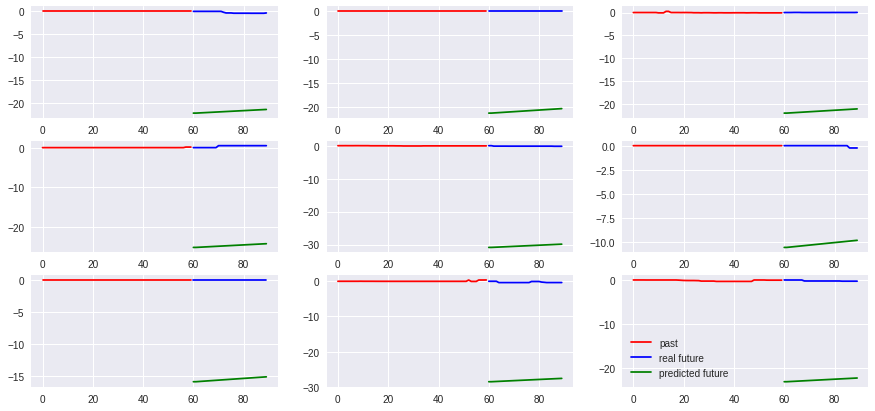

End Epoch 21 (204.043 secs): err(train) = 14.567865, current dec_ins_percent_usage: 0.00
cur dtw score: 3237.44678988


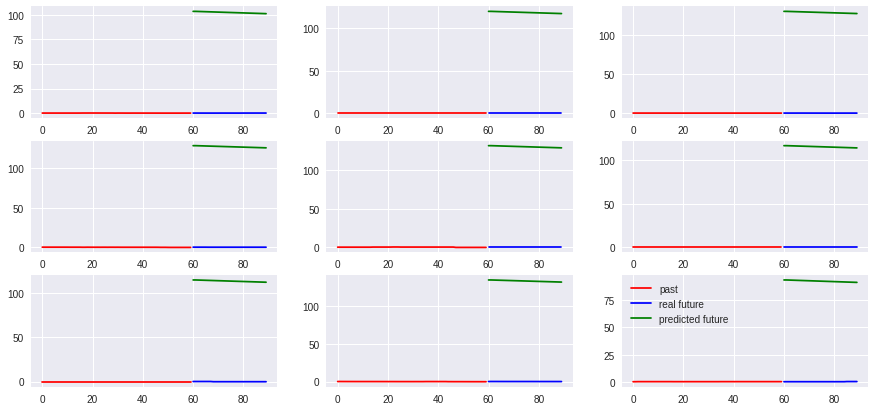

End Epoch 22 (203.995 secs): err(train) = 11.913001, current dec_ins_percent_usage: 0.00
cur dtw score: 1789.6326778


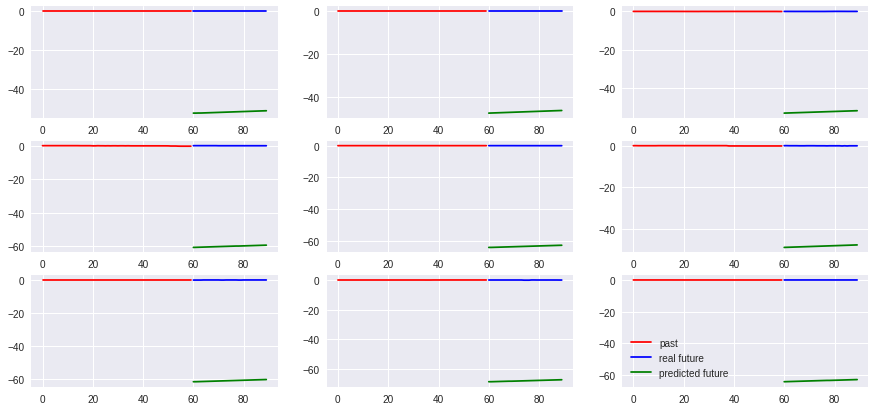

End Epoch 23 (204.056 secs): err(train) = 11.616691, current dec_ins_percent_usage: 0.00
cur dtw score: 596.186367409


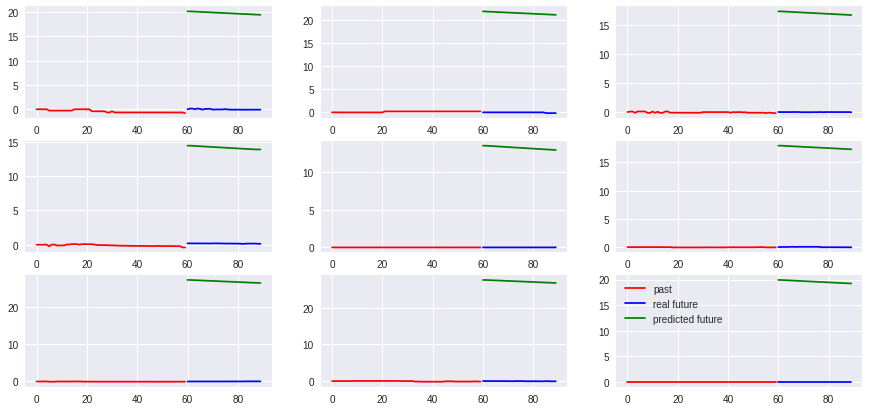

End Epoch 24 (204.022 secs): err(train) = 11.510239, current dec_ins_percent_usage: 0.00
cur dtw score: 3260.74566694


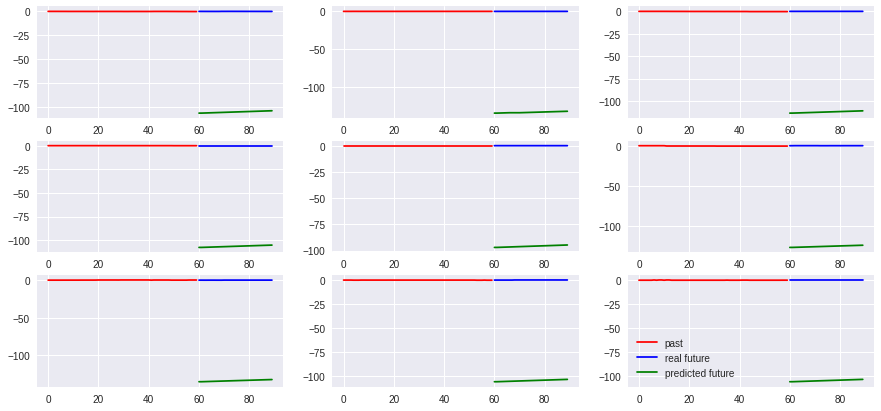

End Epoch 25 (204.119 secs): err(train) = 12.314195, current dec_ins_percent_usage: 0.00
cur dtw score: 3221.04570056


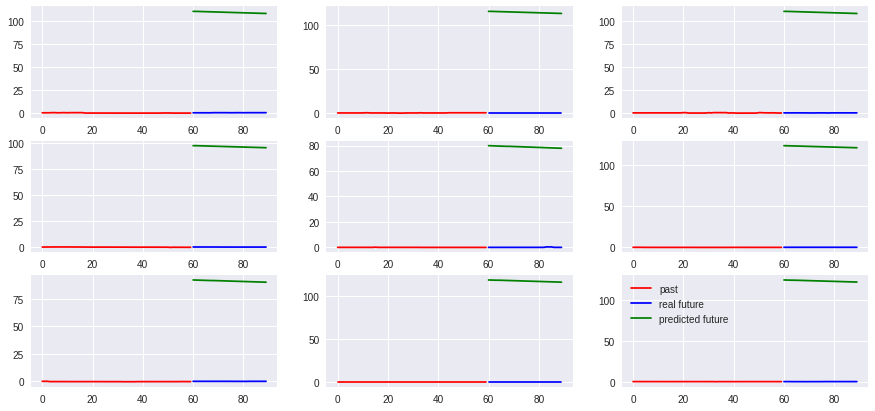

End Epoch 26 (204.062 secs): err(train) = 12.402619, current dec_ins_percent_usage: 0.00
cur dtw score: 9492.95364756


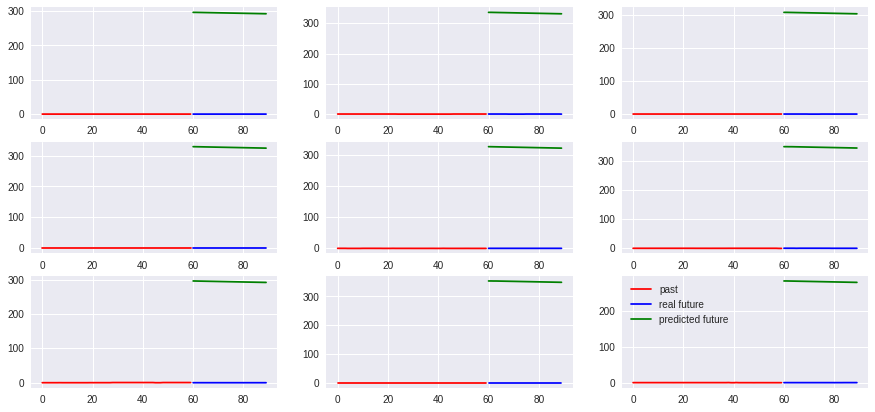

End Epoch 27 (204.067 secs): err(train) = 10.694695, current dec_ins_percent_usage: 0.00
cur dtw score: 767.662410531


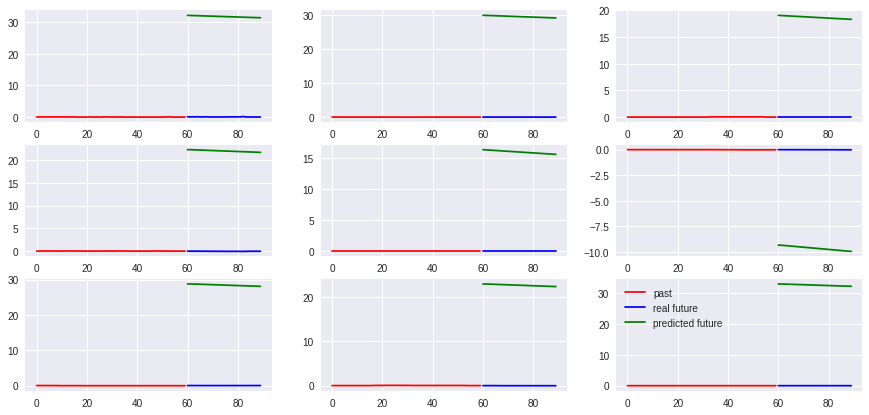

End Epoch 28 (204.116 secs): err(train) = 10.585778, current dec_ins_percent_usage: 0.00
cur dtw score: 7021.08587809


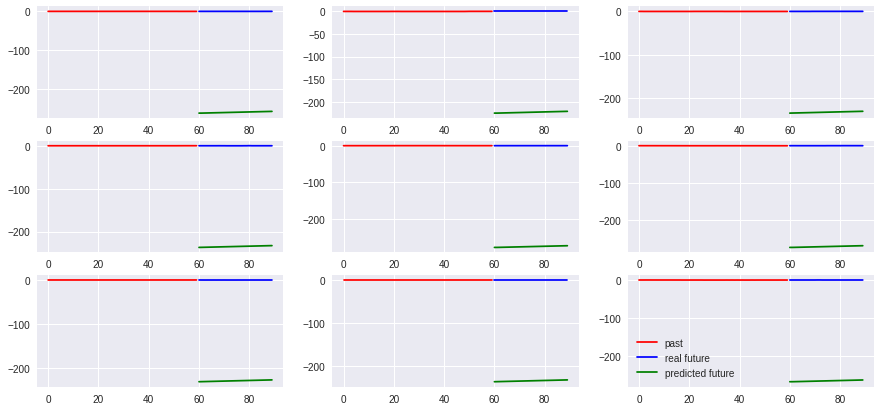

End Epoch 29 (204.093 secs): err(train) = 12.123351, current dec_ins_percent_usage: 0.00
cur dtw score: 2018.81858025


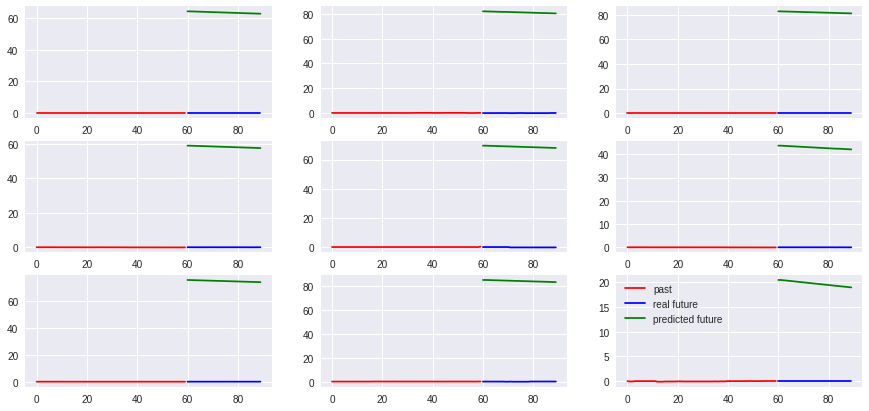

End Epoch 30 (204.043 secs): err(train) = 12.414842, current dec_ins_percent_usage: 0.00
cur dtw score: 634.032294424


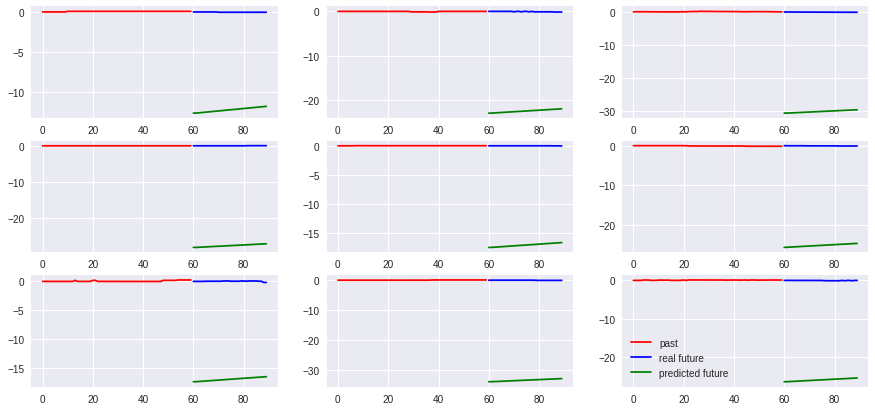

End Epoch 31 (204.052 secs): err(train) = 11.814323, current dec_ins_percent_usage: 0.00
cur dtw score: 4704.97526771


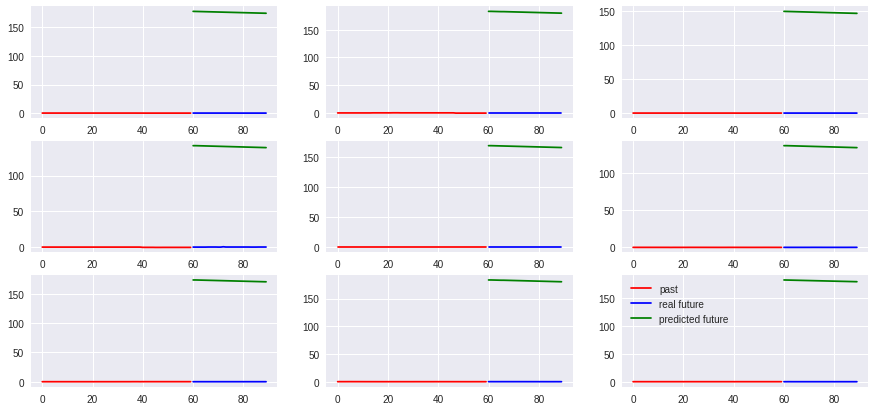

End Epoch 32 (203.982 secs): err(train) = 12.352711, current dec_ins_percent_usage: 0.00
cur dtw score: 3276.4890257


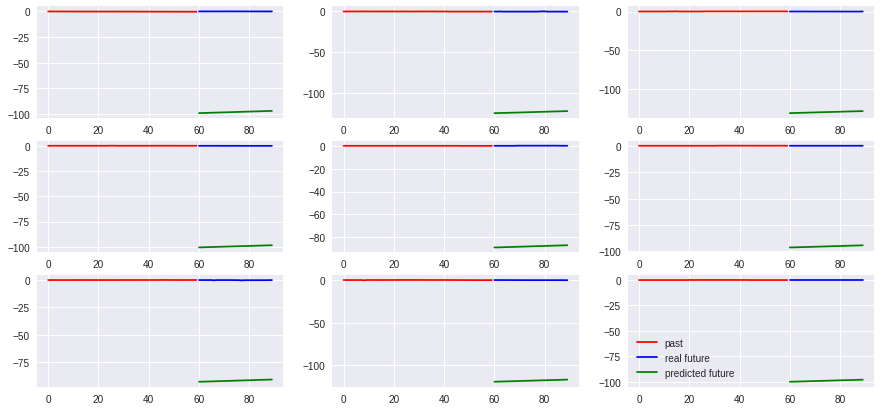

End Epoch 33 (203.950 secs): err(train) = 10.153439, current dec_ins_percent_usage: 0.00
cur dtw score: 2408.11755295


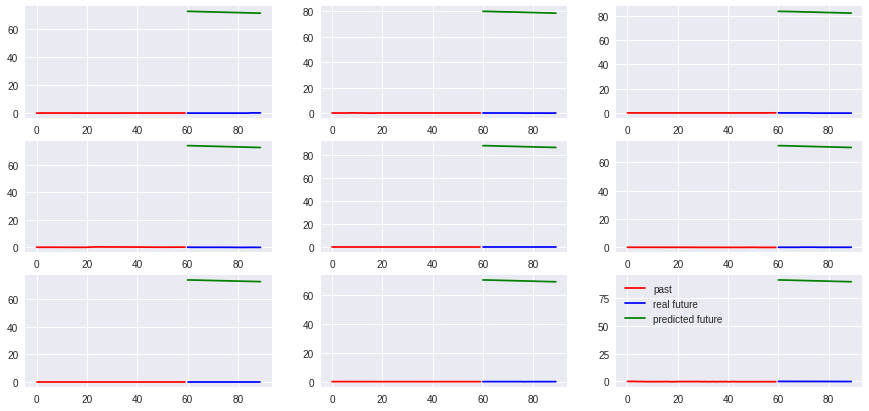

End Epoch 34 (203.994 secs): err(train) = 9.256276, current dec_ins_percent_usage: 0.00
cur dtw score: 4720.91616907


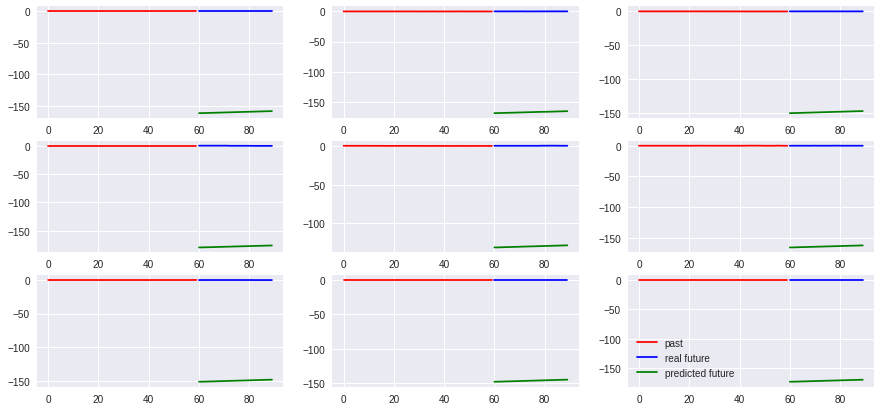

End Epoch 35 (204.028 secs): err(train) = 9.531593, current dec_ins_percent_usage: 0.00
cur dtw score: 10573.8050322


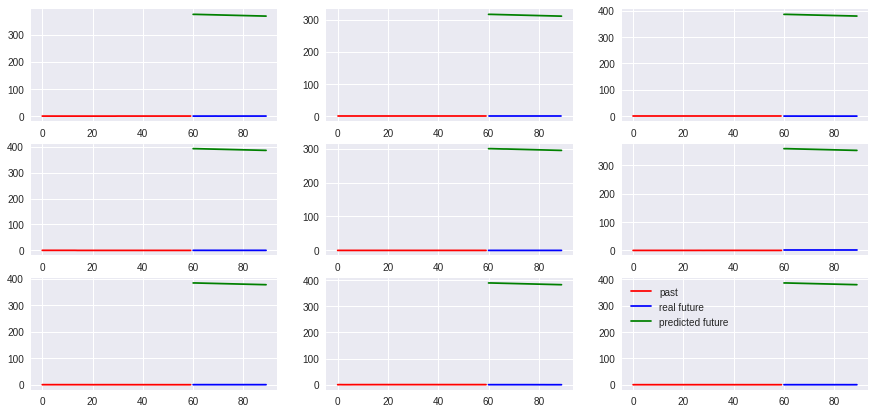

End Epoch 36 (204.091 secs): err(train) = 14.029604, current dec_ins_percent_usage: 0.00
cur dtw score: 1746.12314082


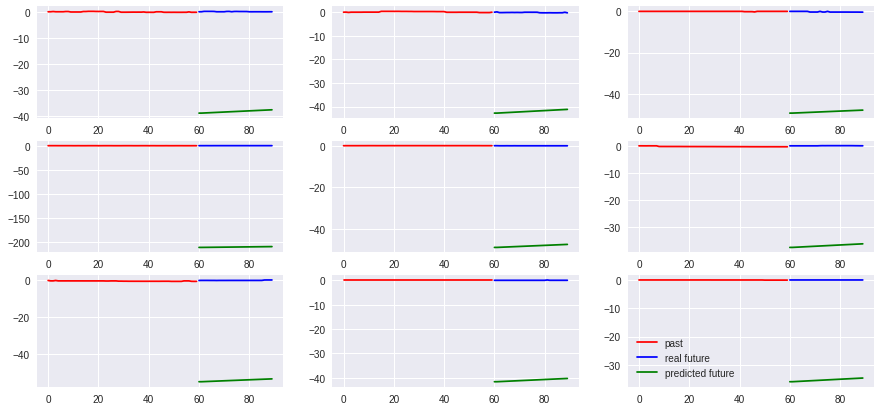

End Epoch 37 (203.982 secs): err(train) = 13.625421, current dec_ins_percent_usage: 0.00
cur dtw score: 2251.41716763


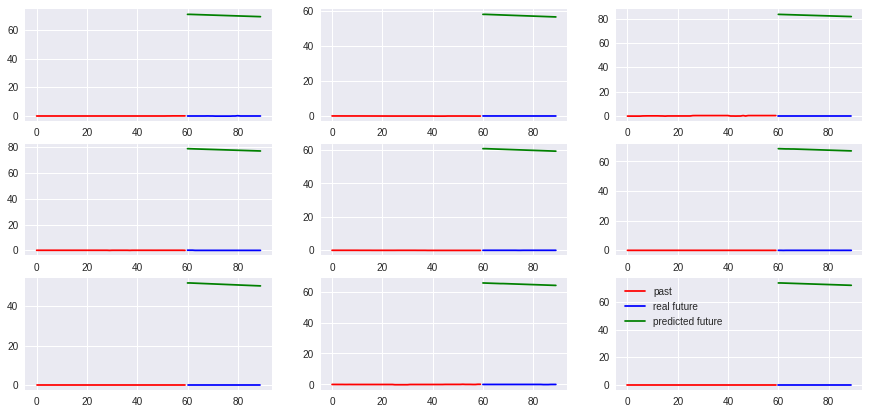

End Epoch 38 (204.015 secs): err(train) = 11.716757, current dec_ins_percent_usage: 0.00
cur dtw score: 1055.00808638


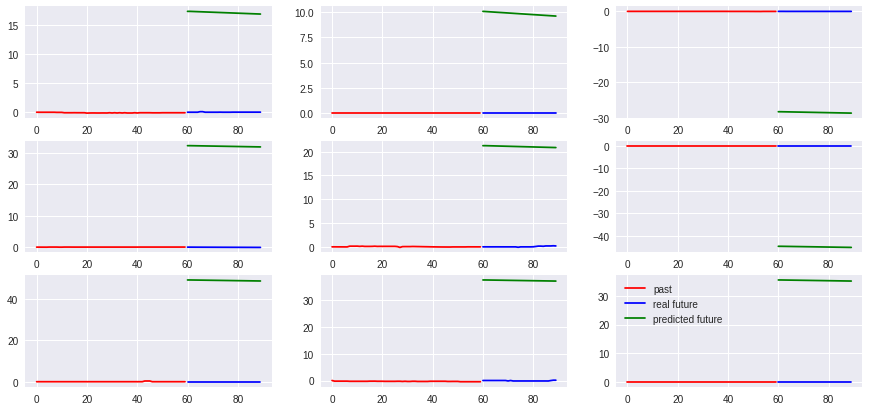

End Epoch 39 (204.067 secs): err(train) = 10.880050, current dec_ins_percent_usage: 0.00
cur dtw score: 72.4052611889


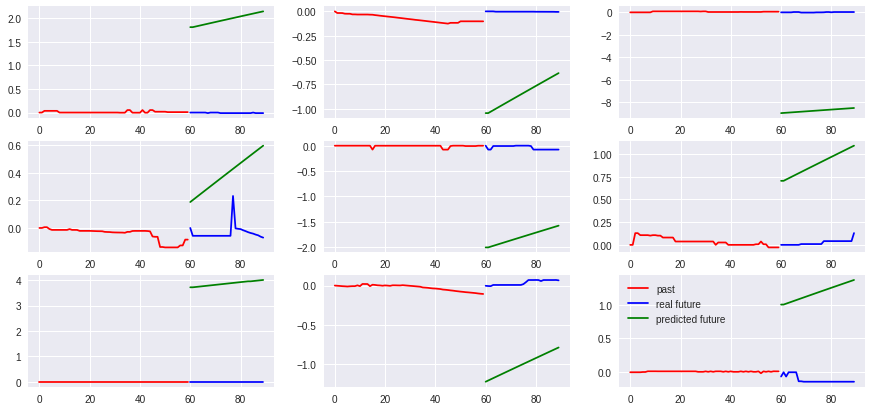

End Epoch 40 (203.955 secs): err(train) = 10.290354, current dec_ins_percent_usage: 0.00
cur dtw score: 46.8501721675


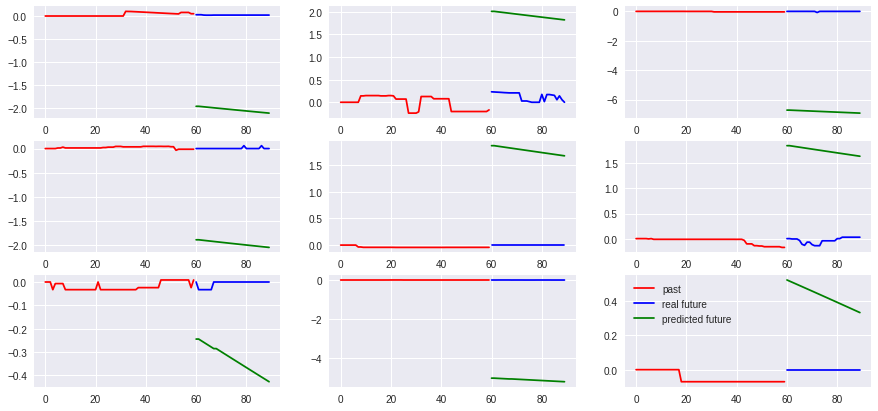

End Epoch 41 (203.955 secs): err(train) = 11.350837, current dec_ins_percent_usage: 0.00
cur dtw score: 1504.69062911


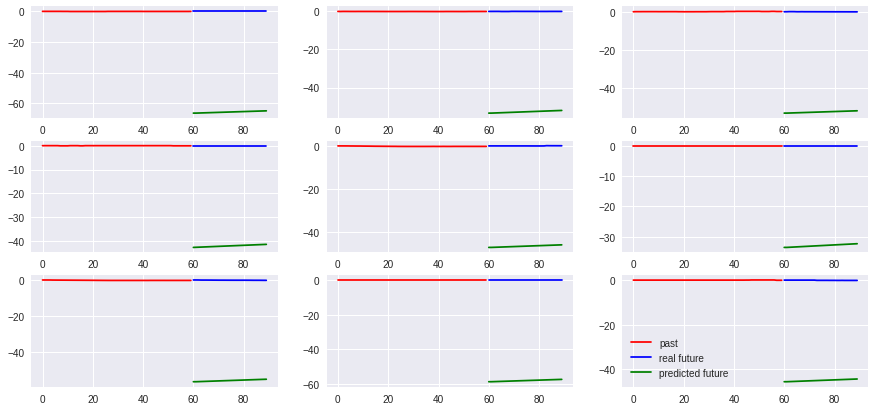

End Epoch 42 (204.051 secs): err(train) = 12.365211, current dec_ins_percent_usage: 0.00
cur dtw score: 6906.05587657


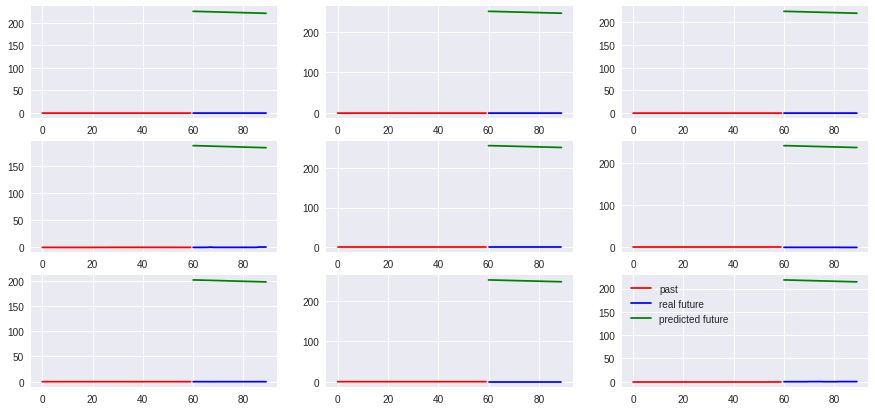

End Epoch 43 (203.930 secs): err(train) = 11.692120, current dec_ins_percent_usage: 0.00
cur dtw score: 3715.97381768


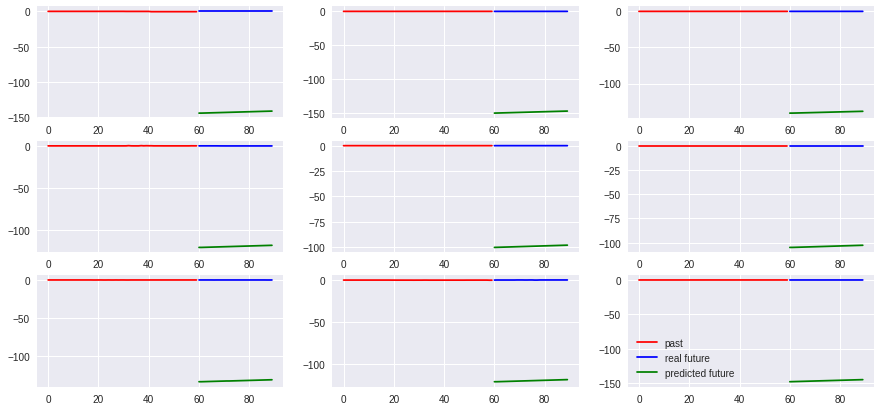

End Epoch 44 (204.159 secs): err(train) = 11.083136, current dec_ins_percent_usage: 0.00
cur dtw score: 618.800546219


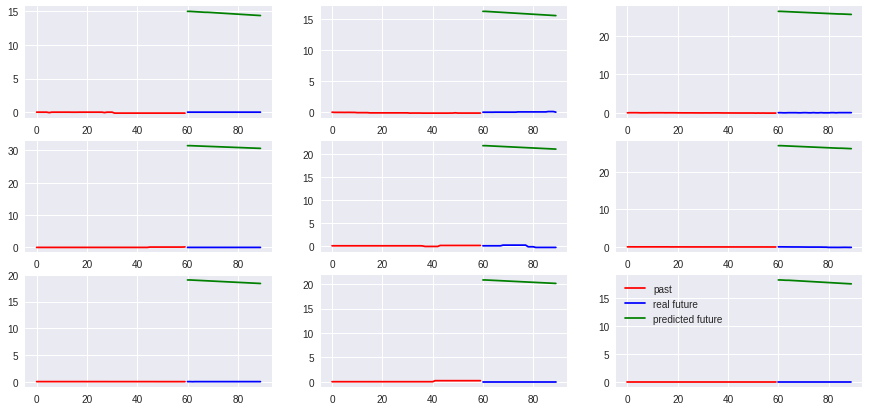

End Epoch 45 (204.018 secs): err(train) = 10.940062, current dec_ins_percent_usage: 0.00
cur dtw score: 1398.56139109


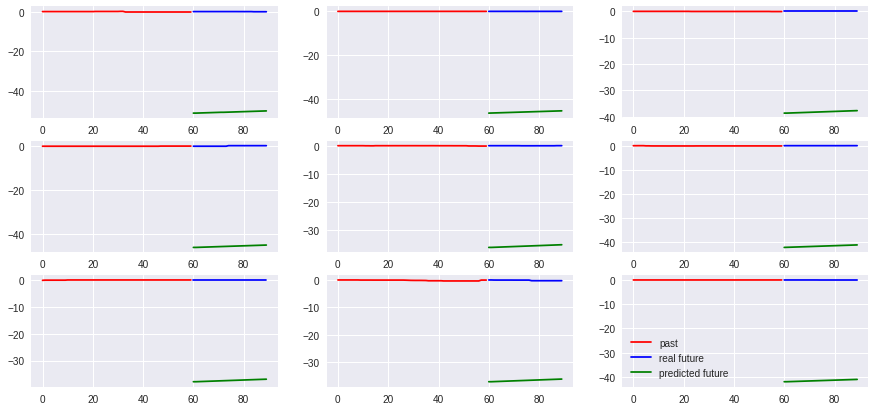

End Epoch 46 (203.963 secs): err(train) = 13.387765, current dec_ins_percent_usage: 0.00
cur dtw score: 2265.54603356


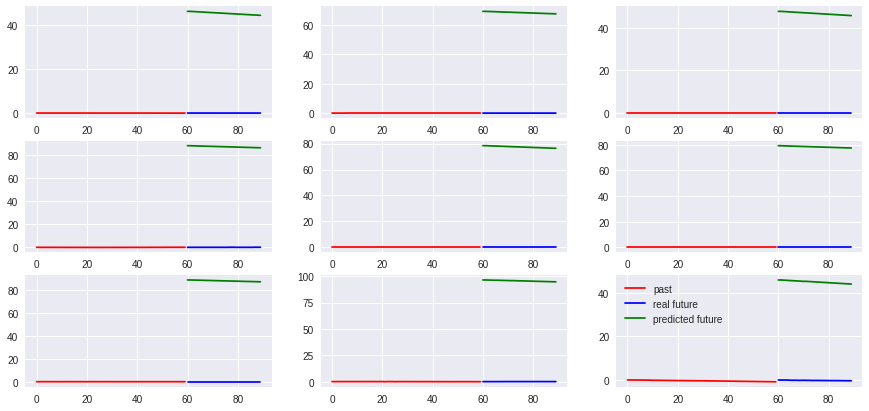

End Epoch 47 (204.005 secs): err(train) = 13.128091, current dec_ins_percent_usage: 0.00
cur dtw score: 15158.6456887


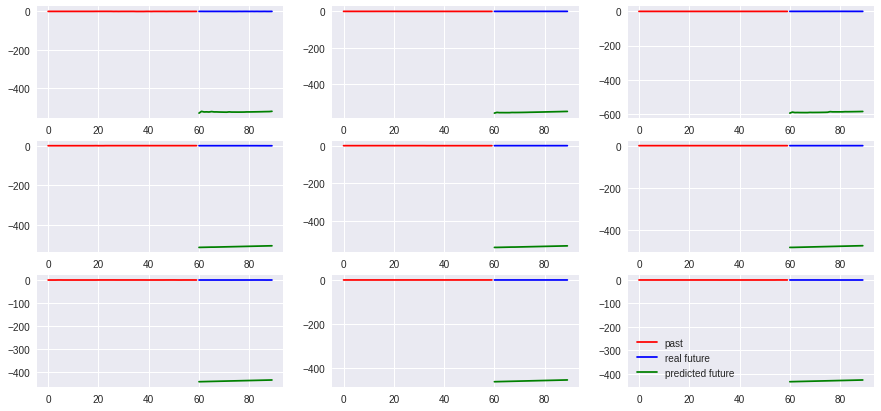

End Epoch 48 (203.952 secs): err(train) = 11.022430, current dec_ins_percent_usage: 0.00
cur dtw score: 1363.62843534


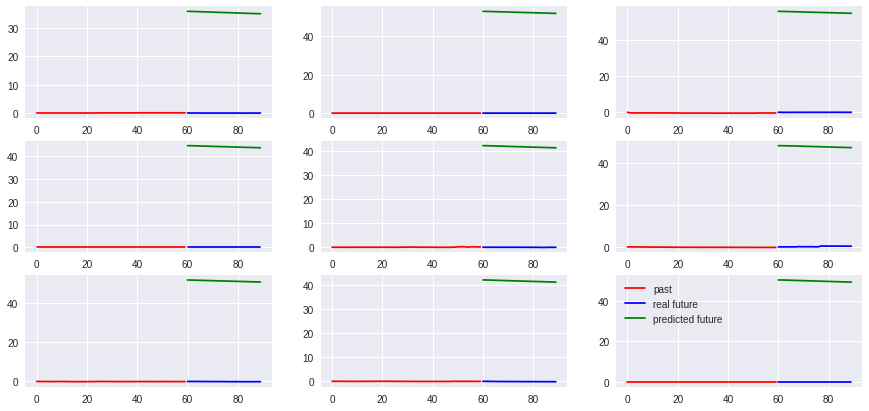

End Epoch 49 (203.876 secs): err(train) = 9.745671, current dec_ins_percent_usage: 0.00
cur dtw score: 956.214484786


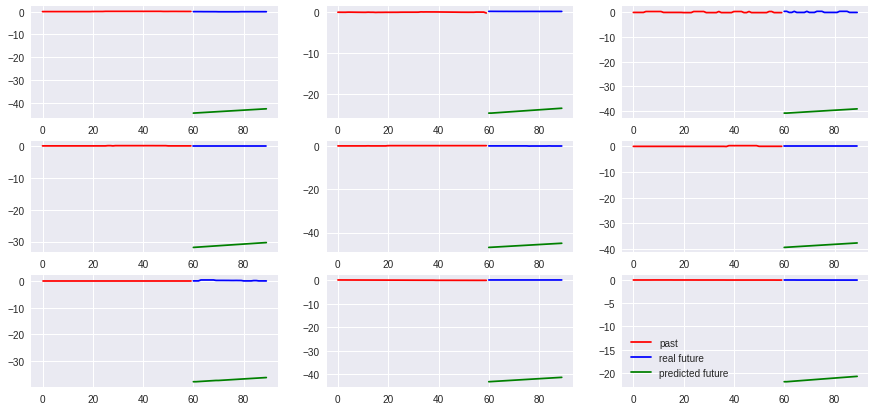

End Epoch 50 (204.061 secs): err(train) = 17.101789, current dec_ins_percent_usage: 0.00
cur dtw score: 123.031076867


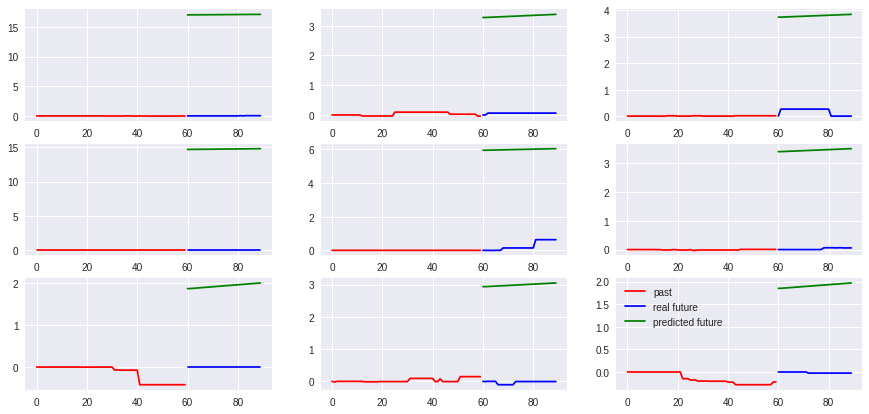

End Epoch 51 (203.997 secs): err(train) = 14.318754, current dec_ins_percent_usage: 0.00
cur dtw score: 2677.97834634


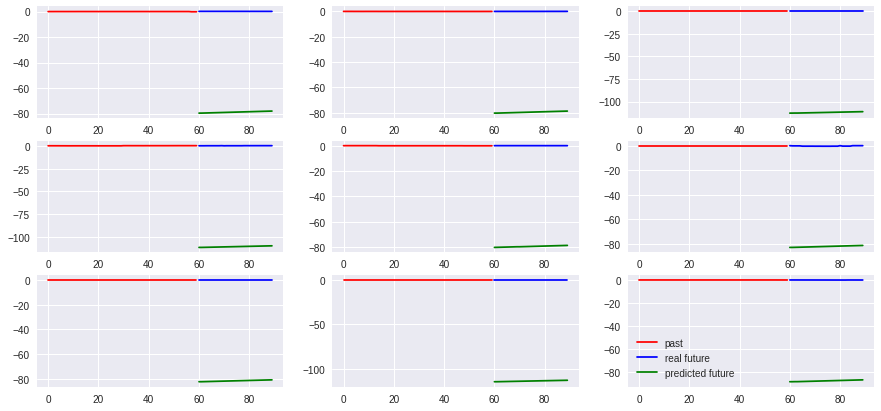

End Epoch 52 (203.914 secs): err(train) = 17.682679, current dec_ins_percent_usage: 0.00
cur dtw score: 214.25539538


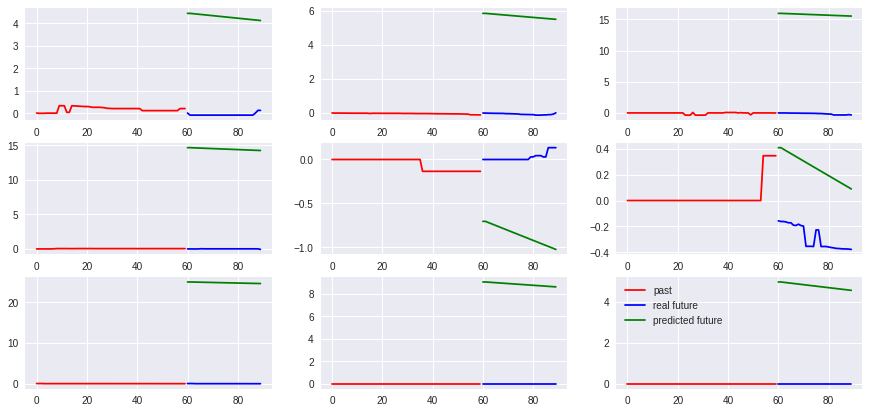

End Epoch 53 (204.033 secs): err(train) = 16.393341, current dec_ins_percent_usage: 0.00
cur dtw score: 95.6187974684


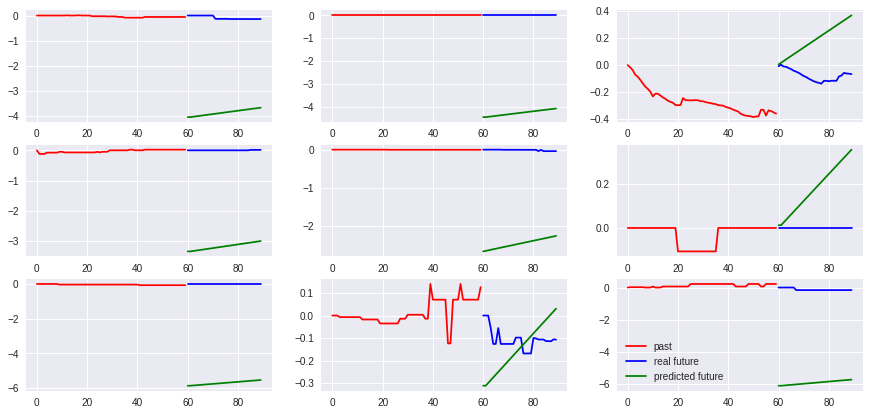

End Epoch 54 (204.026 secs): err(train) = 15.337775, current dec_ins_percent_usage: 0.00
cur dtw score: 185.053566212


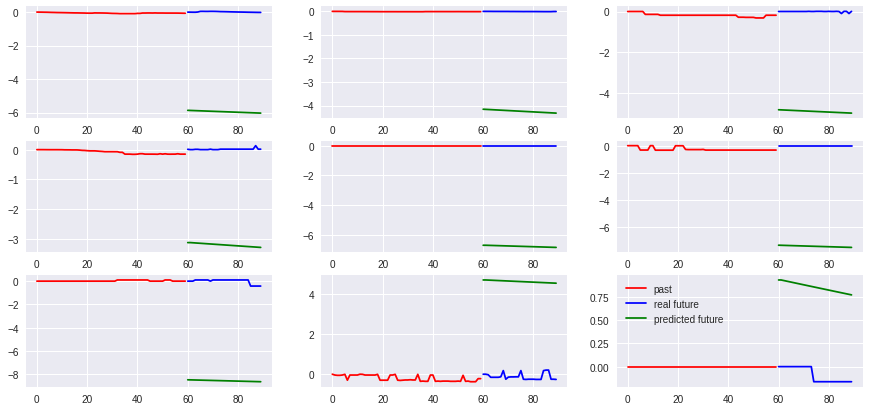

End Epoch 55 (203.946 secs): err(train) = 14.876396, current dec_ins_percent_usage: 0.00
cur dtw score: 1265.06274831


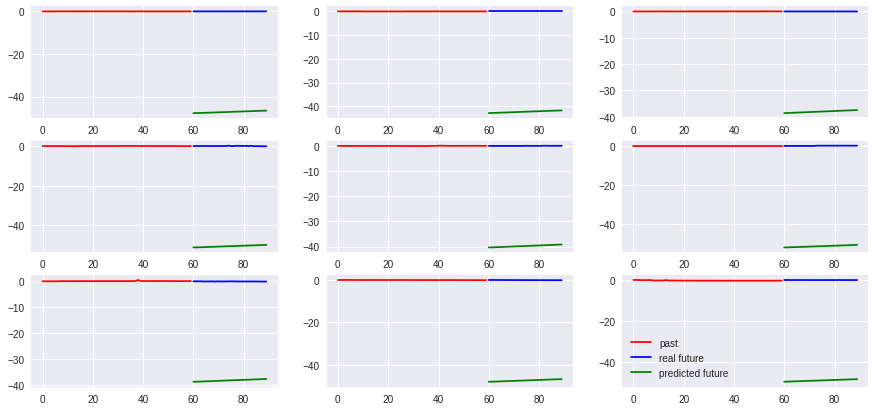

End Epoch 56 (203.932 secs): err(train) = 14.463571, current dec_ins_percent_usage: 0.00
cur dtw score: 2335.93982798


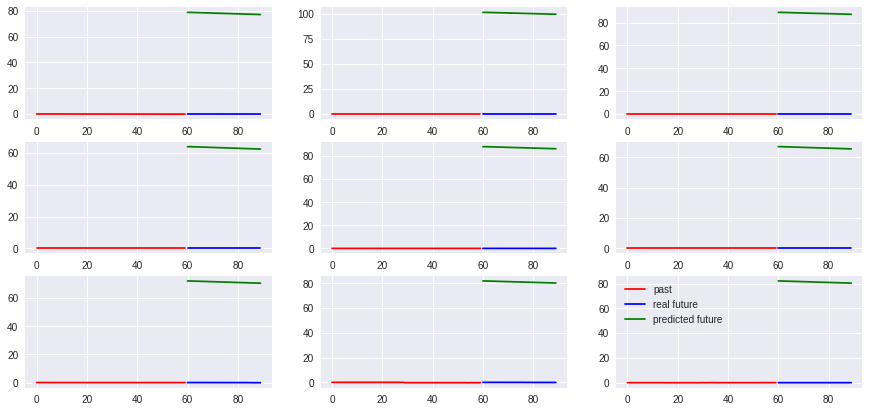

End Epoch 57 (204.024 secs): err(train) = 14.166665, current dec_ins_percent_usage: 0.00
cur dtw score: 2396.05816475


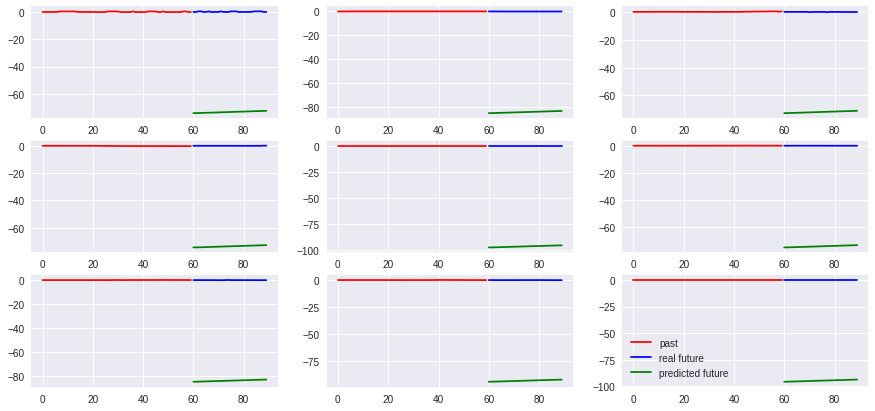

End Epoch 58 (206.889 secs): err(train) = 14.229128, current dec_ins_percent_usage: 0.00
cur dtw score: 1747.76566647


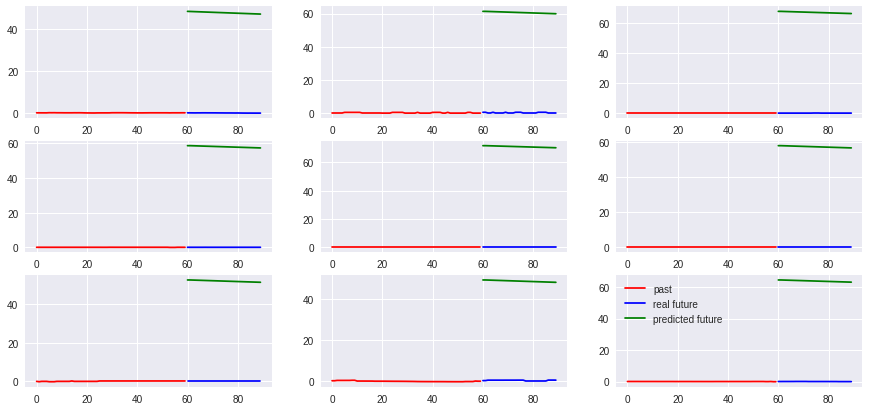

End Epoch 59 (204.682 secs): err(train) = 14.401833, current dec_ins_percent_usage: 0.00
cur dtw score: 1933.18333927


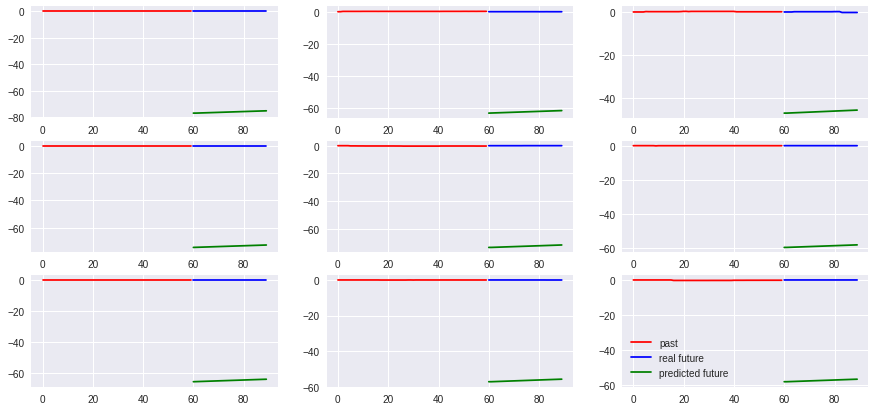

End Epoch 60 (204.554 secs): err(train) = 13.941482, current dec_ins_percent_usage: 0.00
cur dtw score: 1112.46820535


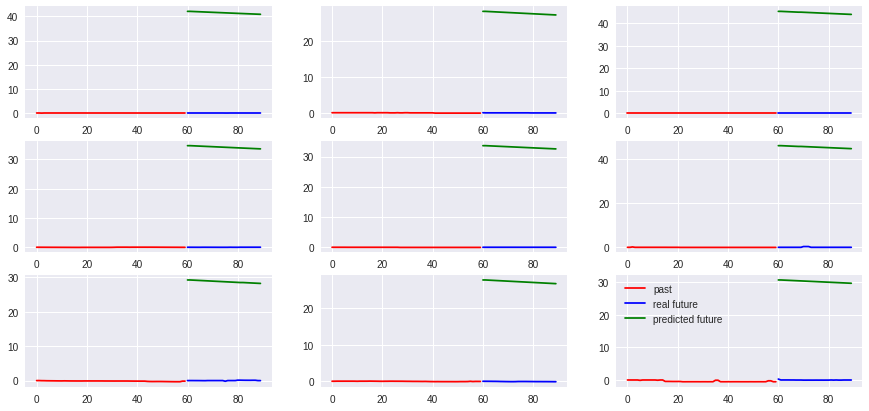

End Epoch 61 (204.564 secs): err(train) = 13.807125, current dec_ins_percent_usage: 0.00
cur dtw score: 3197.40031607


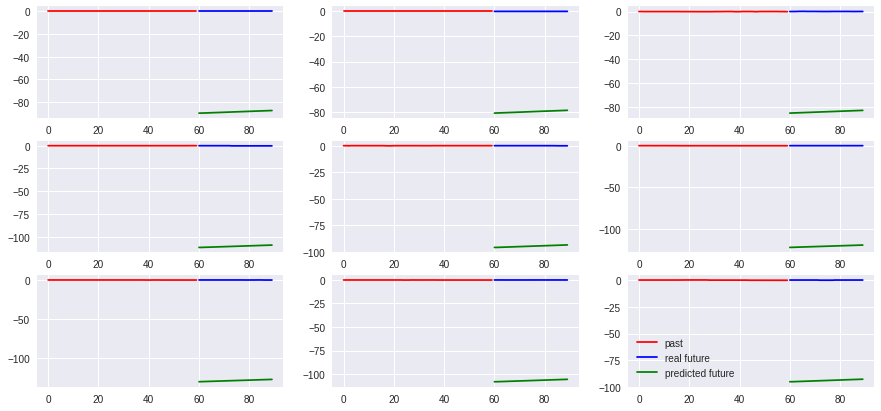

End Epoch 62 (204.708 secs): err(train) = 13.998445, current dec_ins_percent_usage: 0.00
cur dtw score: 924.046817975


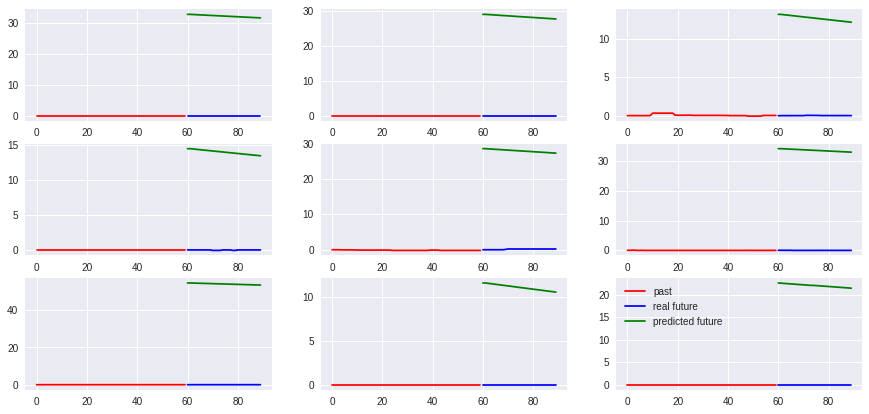

End Epoch 63 (204.559 secs): err(train) = 14.029858, current dec_ins_percent_usage: 0.00
cur dtw score: 1376.0532872


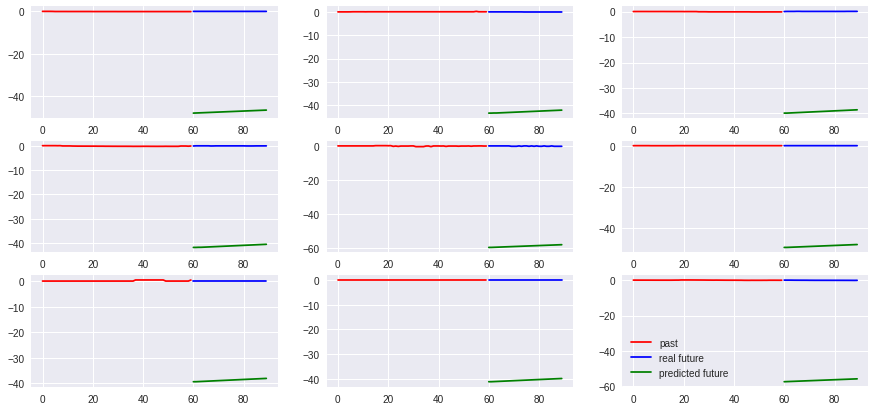

End Epoch 64 (204.542 secs): err(train) = 14.652254, current dec_ins_percent_usage: 0.00
cur dtw score: 936.230096302


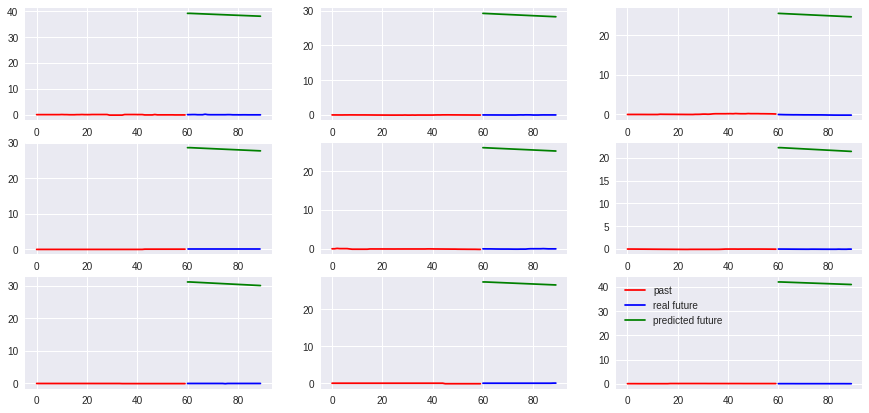

End Epoch 65 (204.513 secs): err(train) = 13.765312, current dec_ins_percent_usage: 0.00
cur dtw score: 2503.48793192


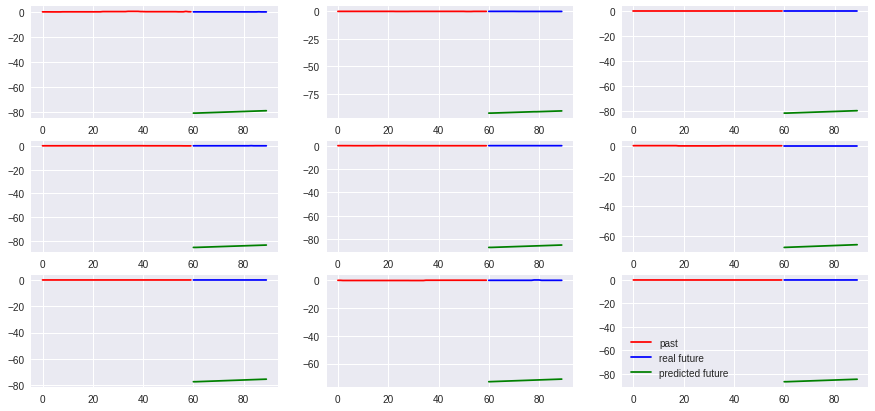

End Epoch 66 (204.546 secs): err(train) = 13.579596, current dec_ins_percent_usage: 0.00
cur dtw score: 627.225207237


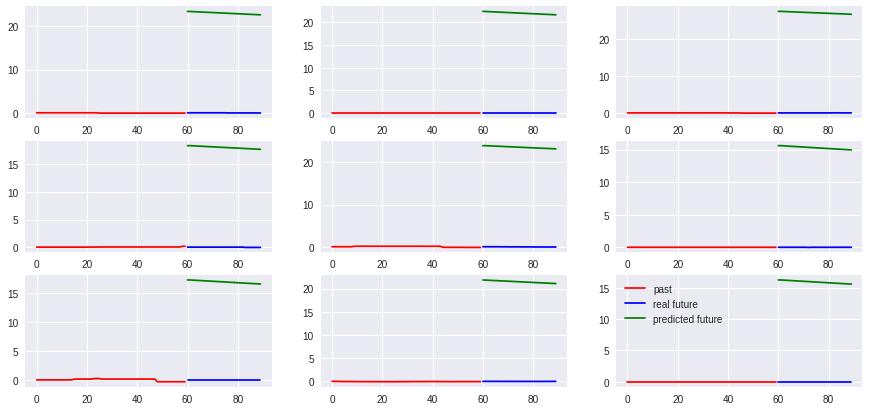

End Epoch 67 (204.514 secs): err(train) = 13.554689, current dec_ins_percent_usage: 0.00
cur dtw score: 2014.8731811


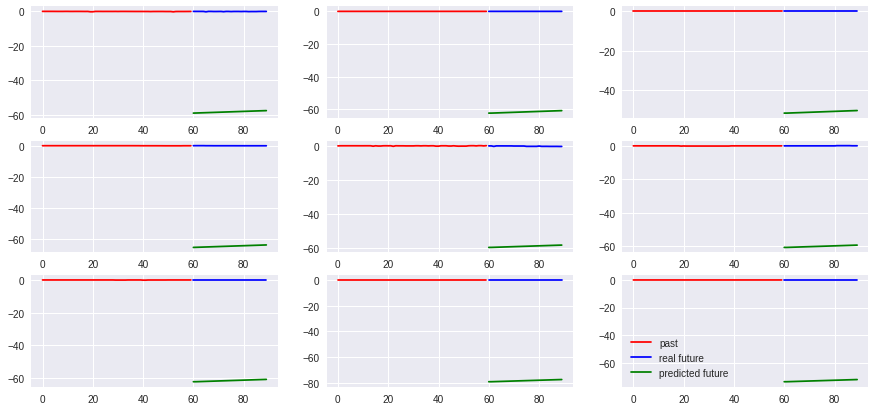

End Epoch 68 (204.674 secs): err(train) = 14.000390, current dec_ins_percent_usage: 0.00
cur dtw score: 1413.28786581


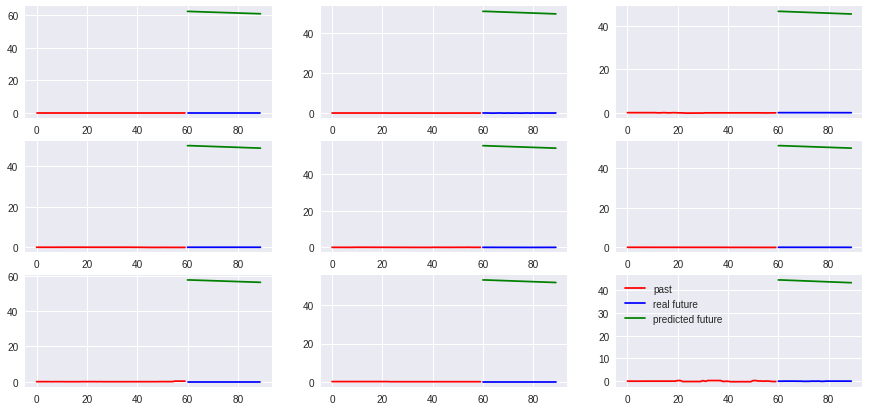

End Epoch 69 (204.708 secs): err(train) = 13.596578, current dec_ins_percent_usage: 0.00
cur dtw score: 1992.59952985


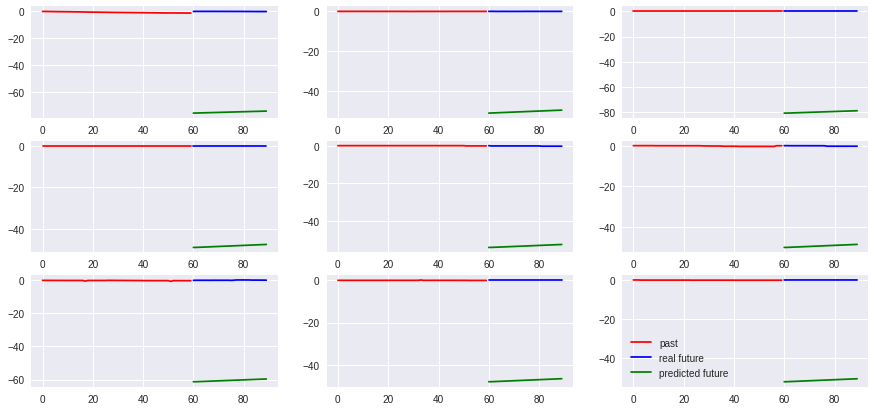

End Epoch 70 (204.604 secs): err(train) = 13.468877, current dec_ins_percent_usage: 0.00
cur dtw score: 10152.823757


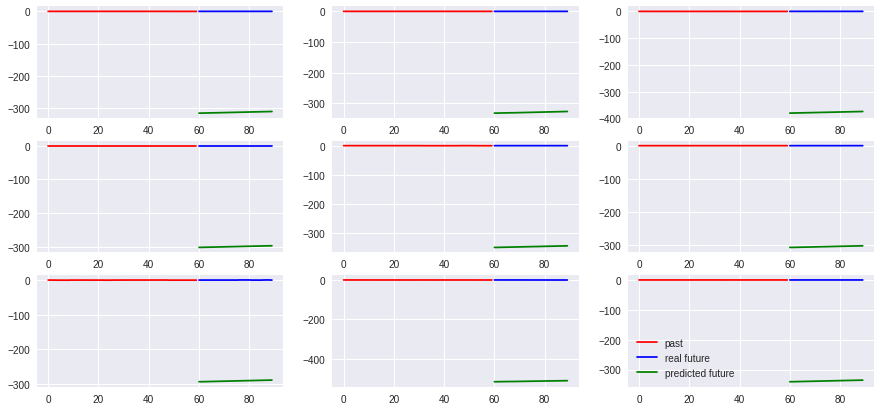

End Epoch 71 (204.540 secs): err(train) = 14.272389, current dec_ins_percent_usage: 0.00
cur dtw score: 1597.29937057


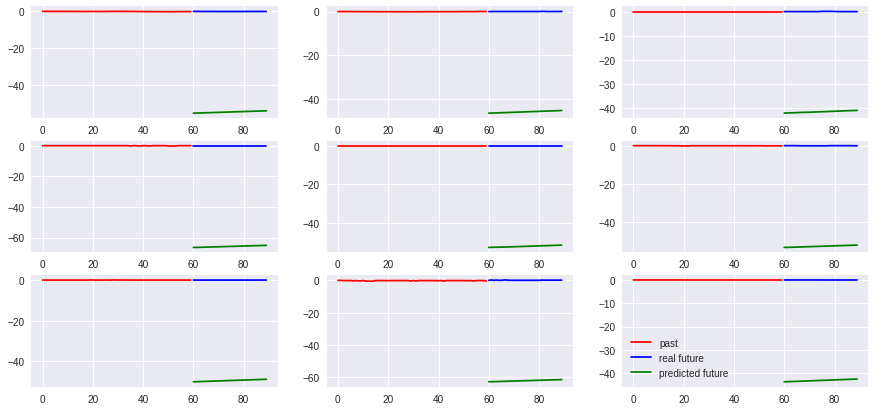

End Epoch 72 (204.597 secs): err(train) = 13.566234, current dec_ins_percent_usage: 0.00
cur dtw score: 906.782158512


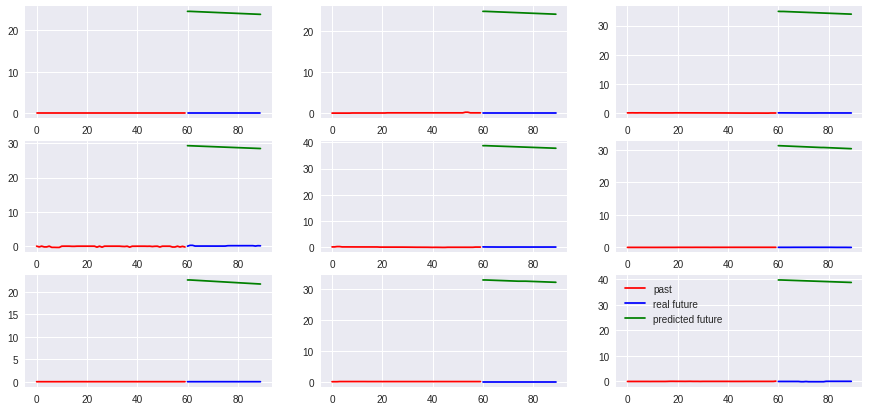

End Epoch 73 (204.536 secs): err(train) = 14.121458, current dec_ins_percent_usage: 0.00
cur dtw score: 508.156462478


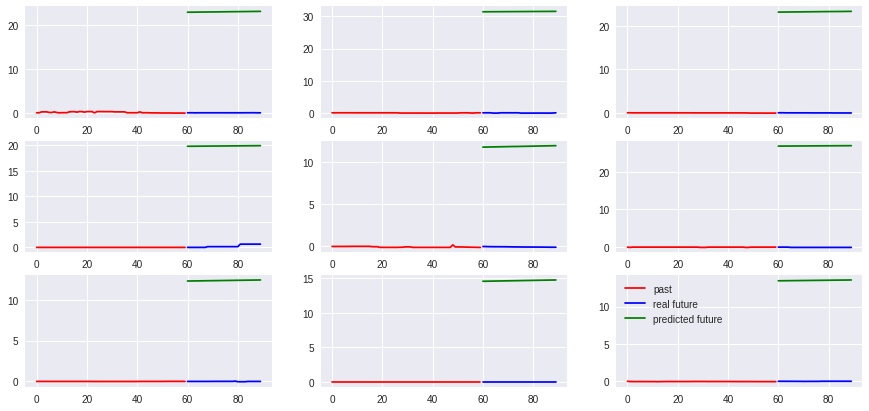

End Epoch 74 (204.487 secs): err(train) = 13.665418, current dec_ins_percent_usage: 0.00
cur dtw score: 12919.8206088


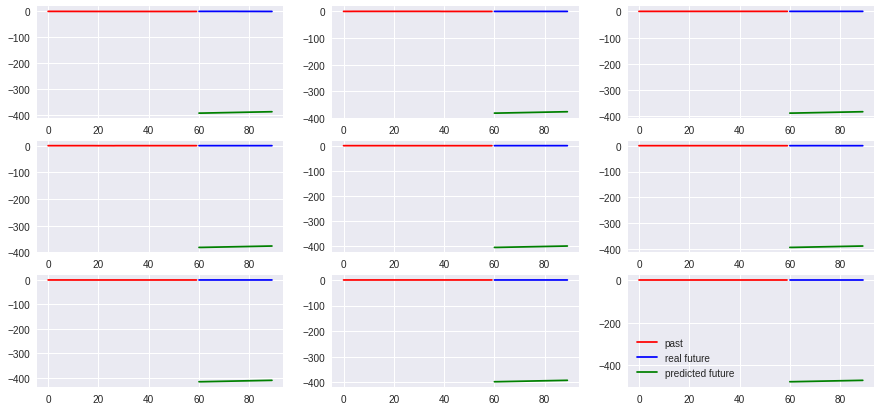

End Epoch 75 (204.638 secs): err(train) = 13.863401, current dec_ins_percent_usage: 0.00
cur dtw score: 196.038893861


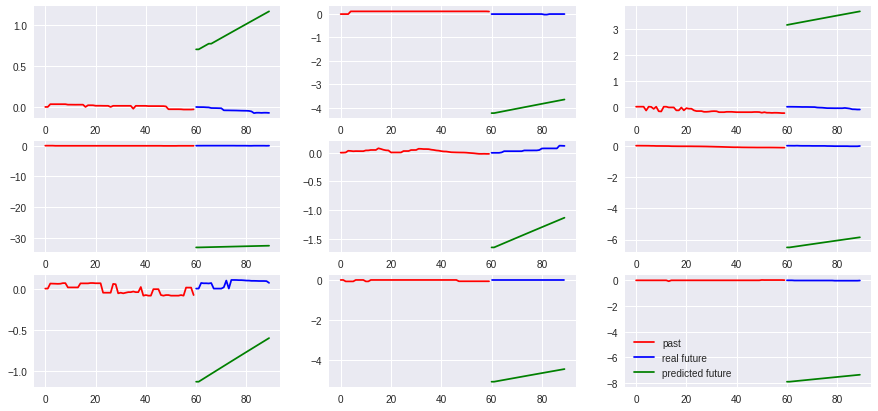

End Epoch 76 (204.628 secs): err(train) = 13.790348, current dec_ins_percent_usage: 0.00
cur dtw score: 4165.79625514


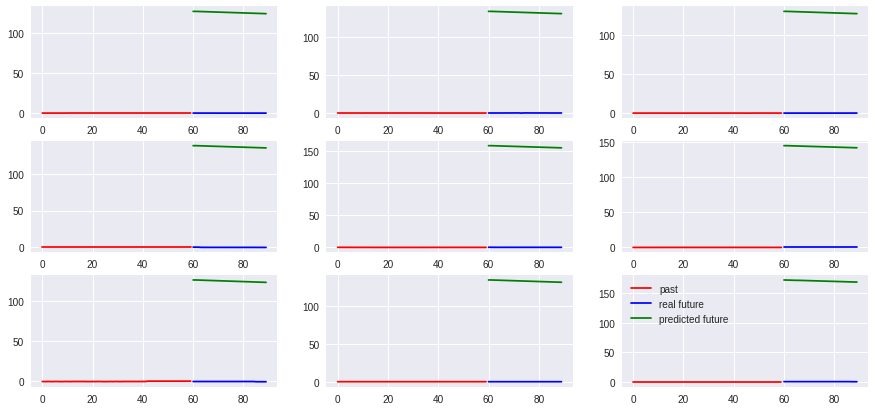

End Epoch 77 (204.560 secs): err(train) = 14.561354, current dec_ins_percent_usage: 0.00
cur dtw score: 552.909623701


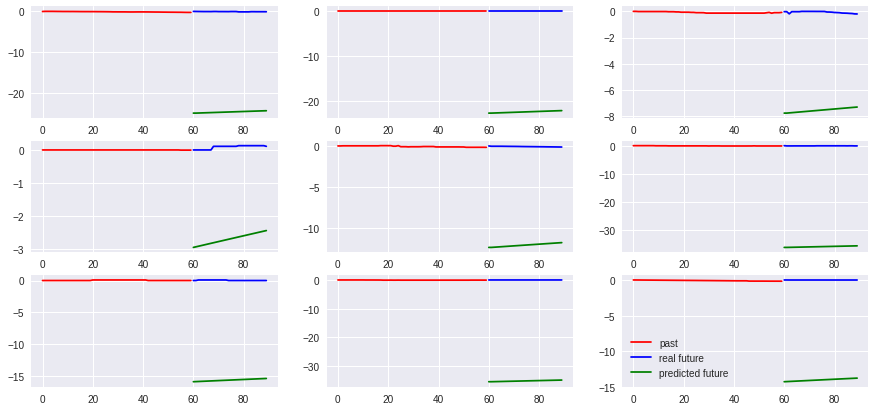

End Epoch 78 (204.508 secs): err(train) = 14.634649, current dec_ins_percent_usage: 0.00
cur dtw score: 1327.47896721


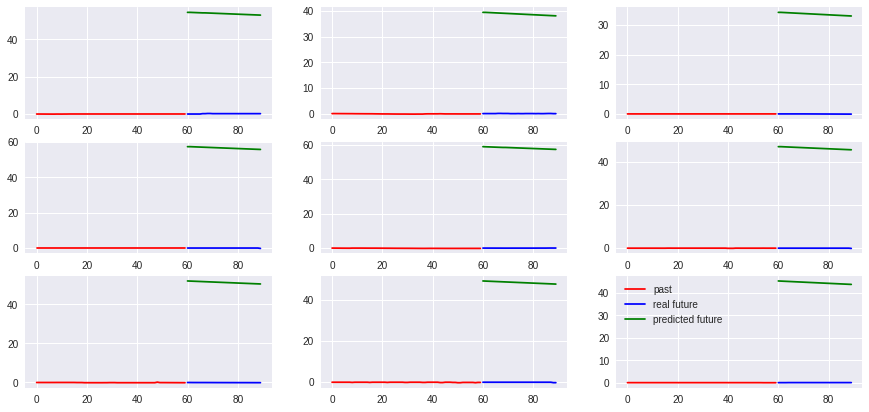

End Epoch 79 (204.575 secs): err(train) = 13.664947, current dec_ins_percent_usage: 0.00
cur dtw score: 2897.65321949


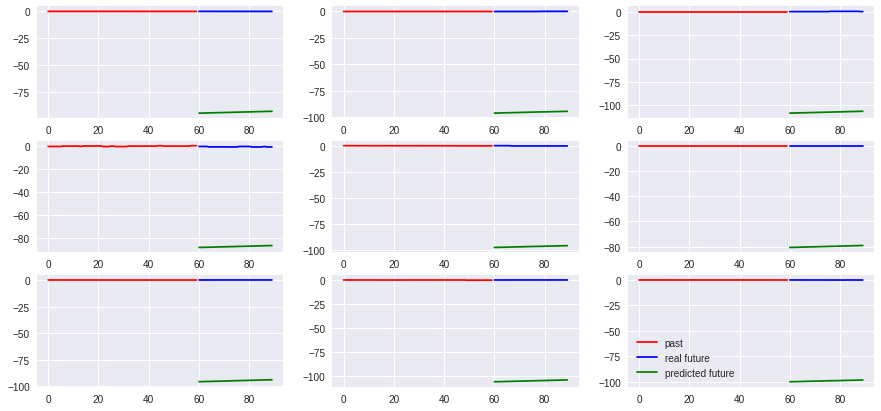

End Epoch 80 (204.552 secs): err(train) = 13.059806, current dec_ins_percent_usage: 0.00
cur dtw score: 1923.12200214


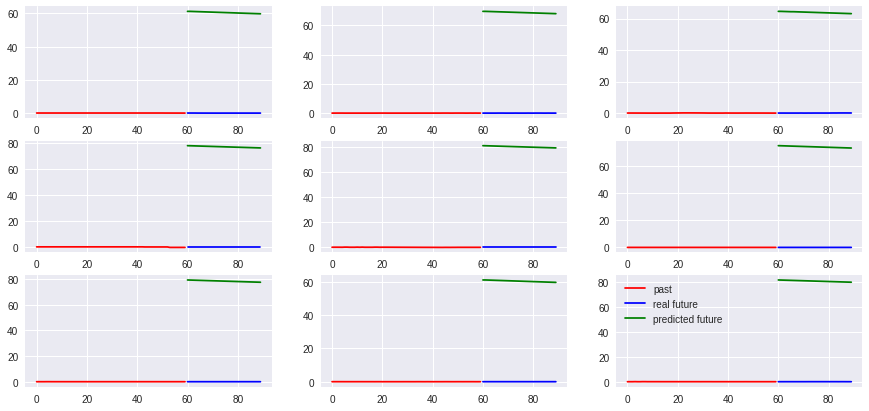

End Epoch 81 (204.541 secs): err(train) = 14.259332, current dec_ins_percent_usage: 0.00
cur dtw score: 269.507468462


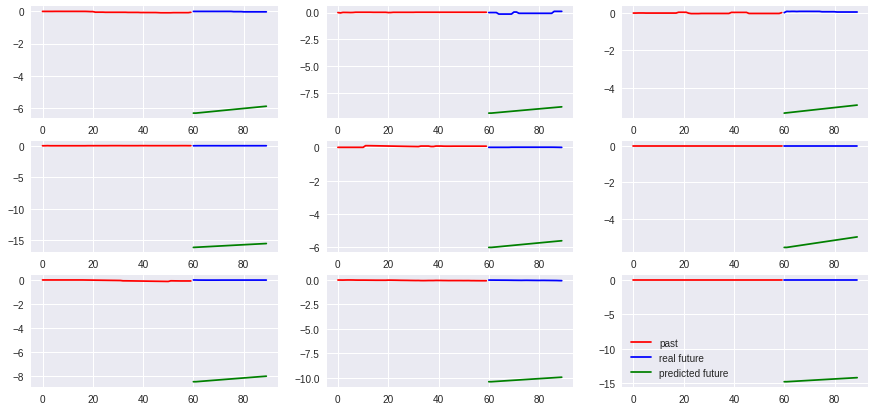

End Epoch 82 (204.548 secs): err(train) = 14.917855, current dec_ins_percent_usage: 0.00
cur dtw score: 4287.80501686


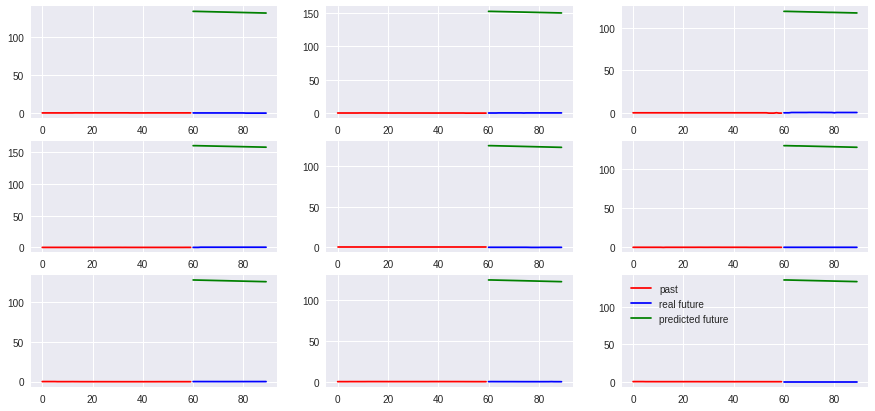

End Epoch 83 (204.543 secs): err(train) = 15.165923, current dec_ins_percent_usage: 0.00
cur dtw score: 1512.34651763


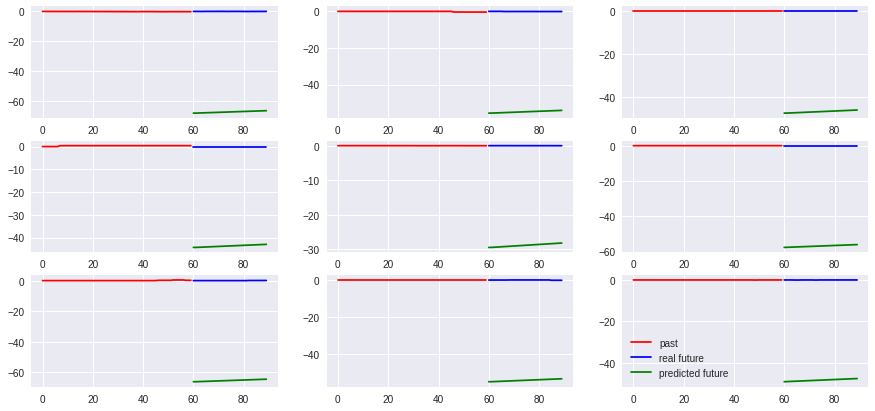

End Epoch 84 (204.591 secs): err(train) = 13.600919, current dec_ins_percent_usage: 0.00
cur dtw score: 3820.51233236


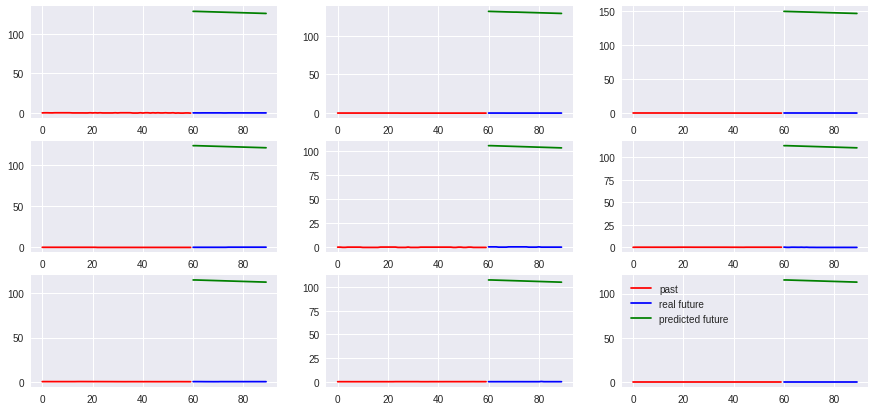

End Epoch 85 (204.511 secs): err(train) = 13.178714, current dec_ins_percent_usage: 0.00
cur dtw score: 230.577046198


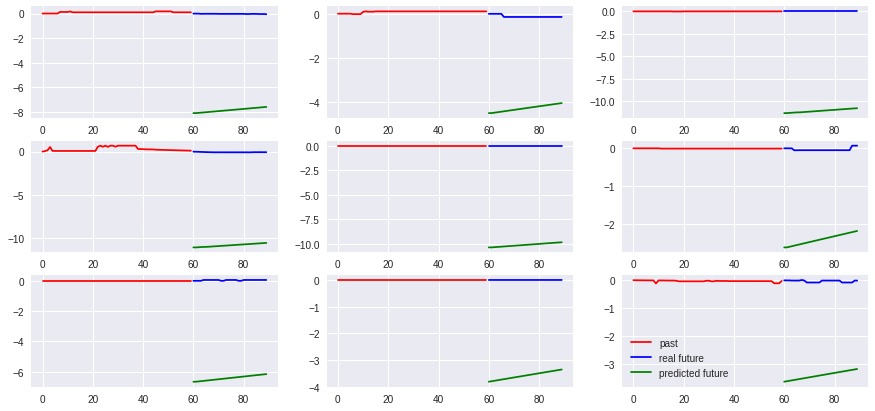

End Epoch 86 (204.658 secs): err(train) = 13.536283, current dec_ins_percent_usage: 0.00
cur dtw score: 1052.03844499


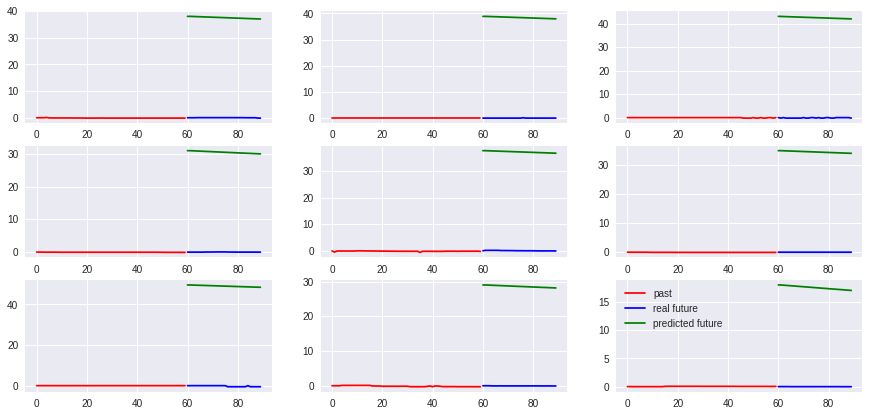

End Epoch 87 (204.543 secs): err(train) = 13.813977, current dec_ins_percent_usage: 0.00
cur dtw score: 3096.93174342


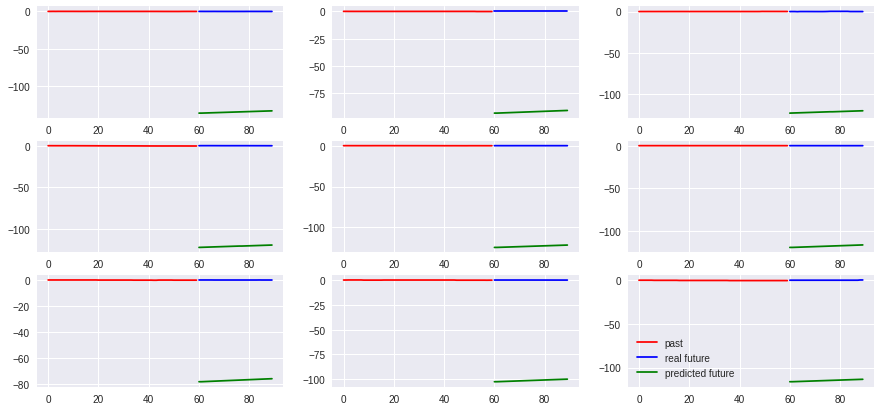

End Epoch 88 (204.601 secs): err(train) = 14.469861, current dec_ins_percent_usage: 0.00
cur dtw score: 126.600389452


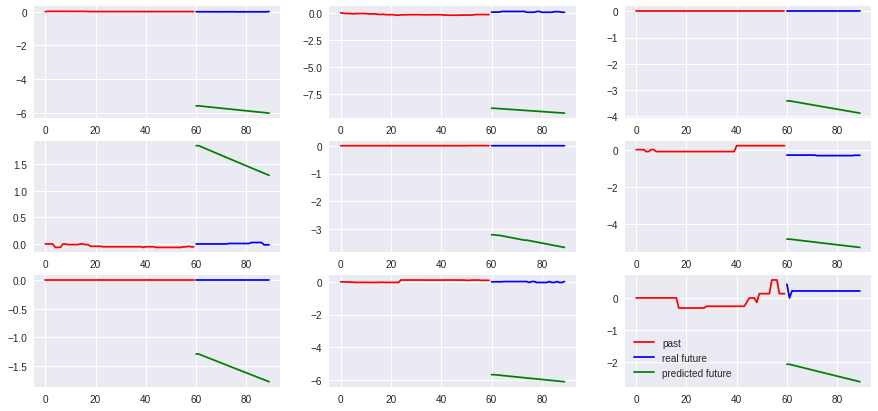

End Epoch 89 (204.620 secs): err(train) = 13.640907, current dec_ins_percent_usage: 0.00
cur dtw score: 2563.78570889


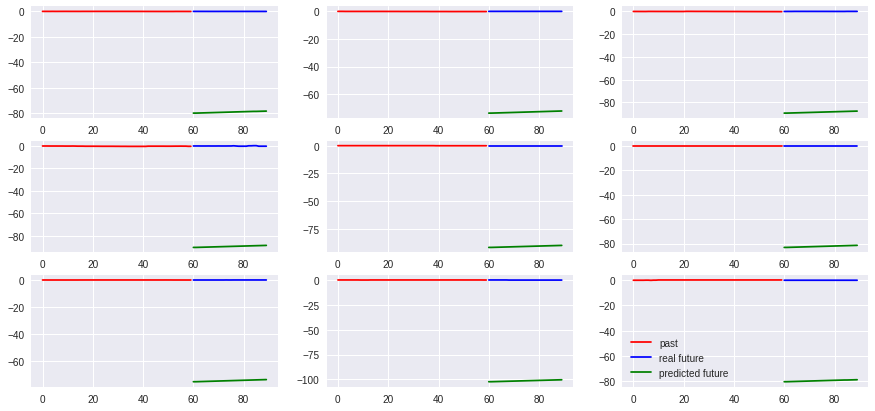

End Epoch 90 (204.607 secs): err(train) = 13.582699, current dec_ins_percent_usage: 0.00
cur dtw score: 728.24849092


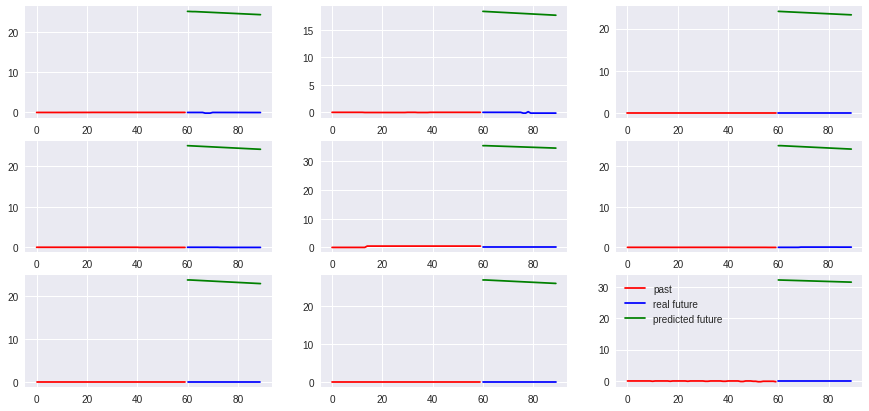

End Epoch 91 (204.518 secs): err(train) = 14.024766, current dec_ins_percent_usage: 0.00
cur dtw score: 1331.44717739


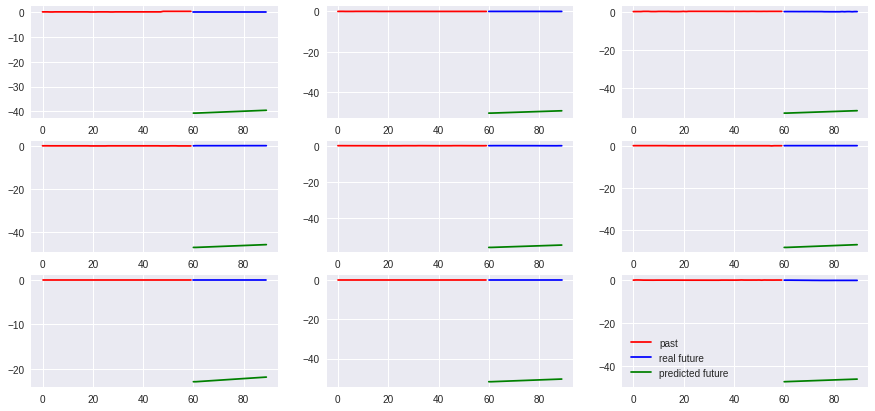

End Epoch 92 (204.531 secs): err(train) = 13.773709, current dec_ins_percent_usage: 0.00
cur dtw score: 12746.4425243


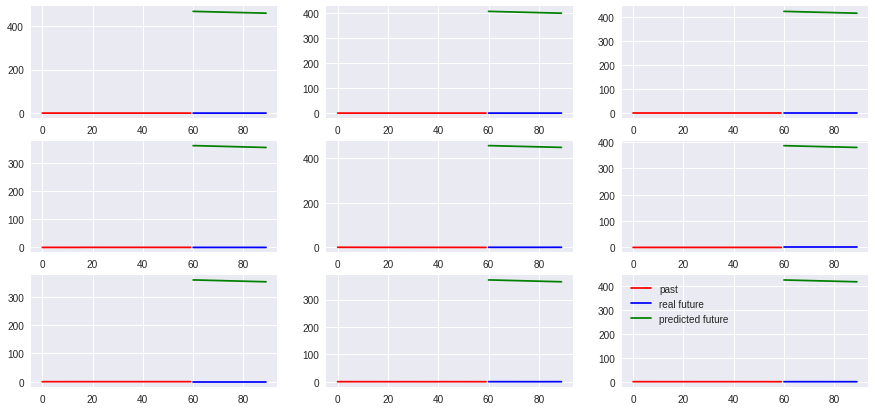

End Epoch 93 (204.493 secs): err(train) = 14.839077, current dec_ins_percent_usage: 0.00
cur dtw score: 1566.59628435


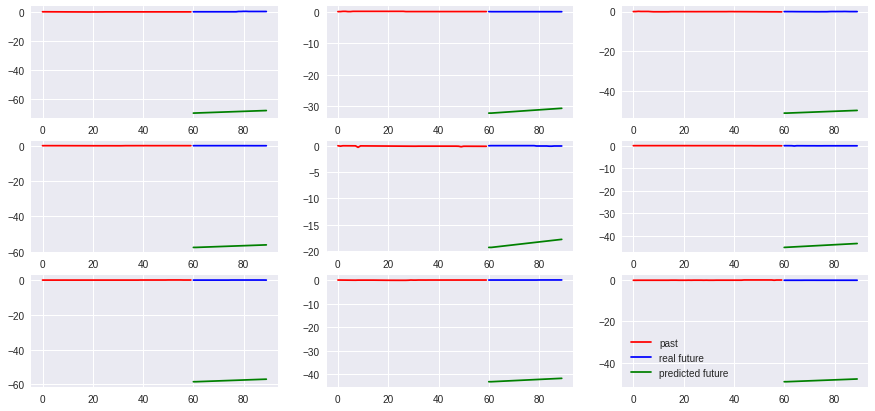

End Epoch 94 (204.530 secs): err(train) = 14.284078, current dec_ins_percent_usage: 0.00
cur dtw score: 2215.60796022


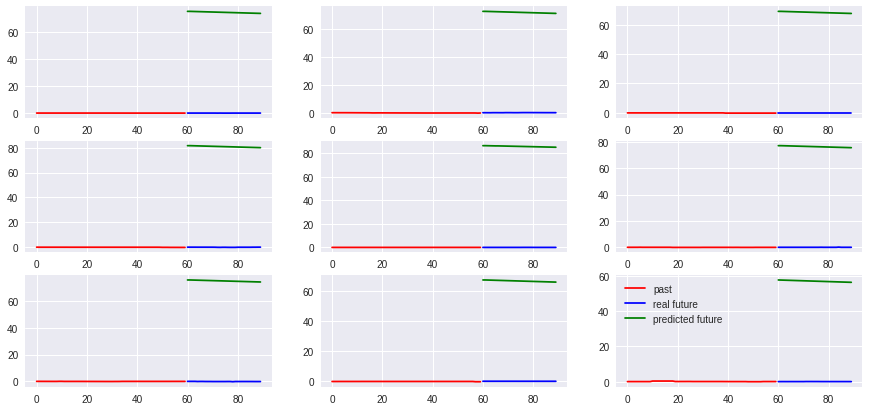

End Epoch 95 (204.519 secs): err(train) = 13.973035, current dec_ins_percent_usage: 0.00
cur dtw score: 1015.59983255


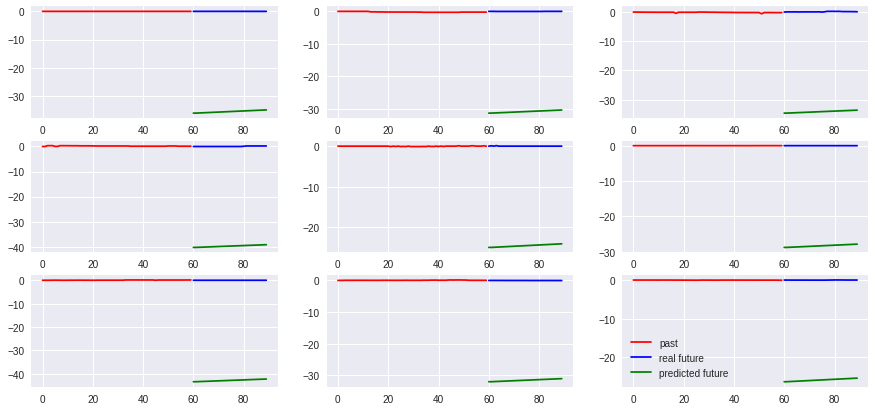

End Epoch 96 (204.500 secs): err(train) = 14.082223, current dec_ins_percent_usage: 0.00
cur dtw score: 2324.32879911


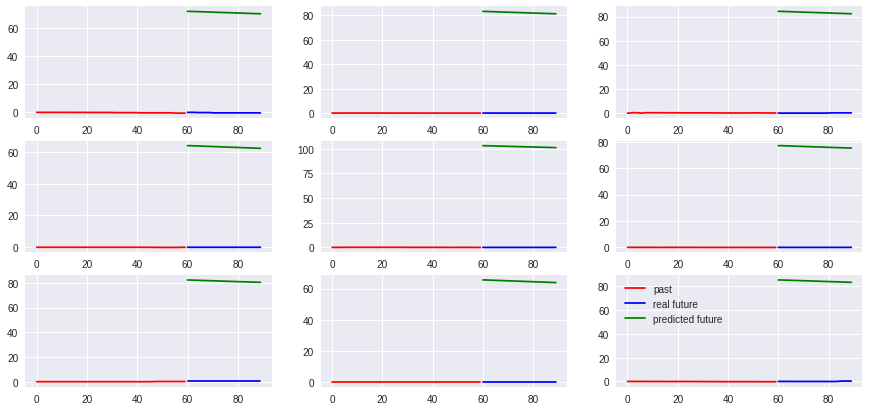

End Epoch 97 (204.416 secs): err(train) = 14.774088, current dec_ins_percent_usage: 0.00
cur dtw score: 1549.09819497


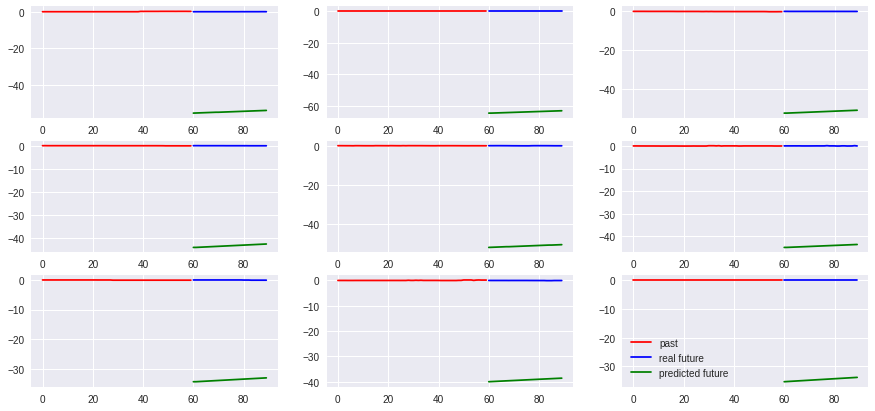

End Epoch 98 (204.480 secs): err(train) = 14.079648, current dec_ins_percent_usage: 0.00
cur dtw score: 800.93844804


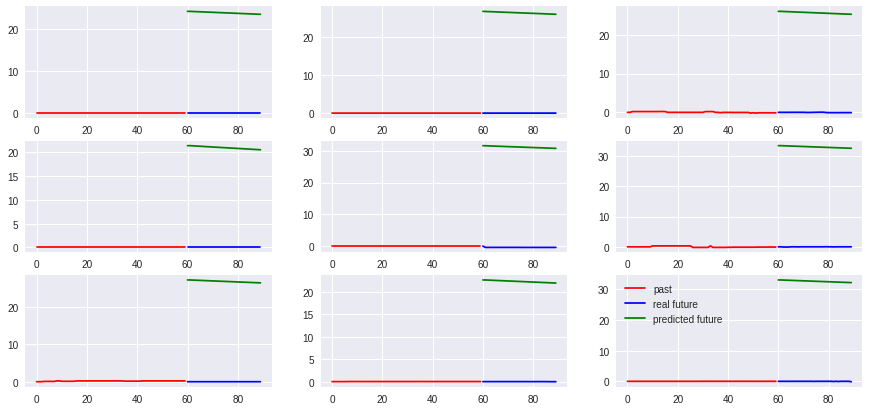

End Epoch 99 (204.588 secs): err(train) = 13.218947, current dec_ins_percent_usage: 0.00
cur dtw score: 595.987946844


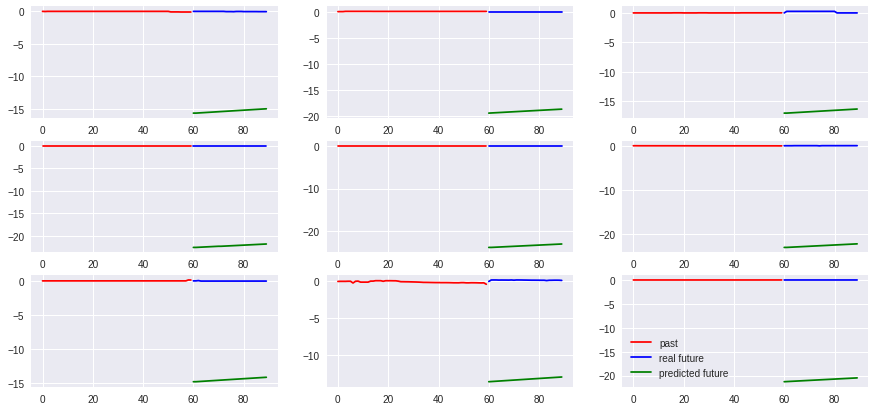

End Epoch 100 (204.582 secs): err(train) = 13.418175, current dec_ins_percent_usage: 0.00
cur dtw score: 2303.25807903


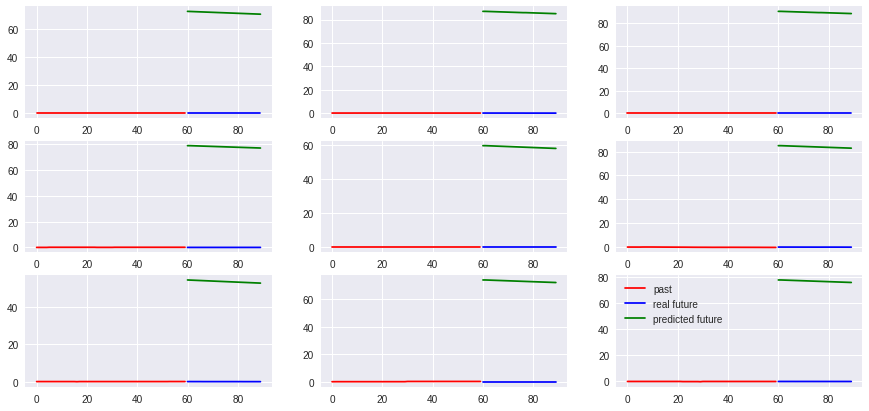

total test error: 76.2752708435



IOError: [Errno 2] No such file or directory: '../data/nn_runs/027a_seq2seq_60to30_000.npz'

In [27]:
#%%time
dyn_stats, preds_dict, targets = get_or_run_nn(experiment, filename='027a_seq2seq_60to30_000')

In [ ]:
dyn_stats.plotStats()
plt.show()

In [ ]:
r2_scores = [r2_score(y_true=targets[ind], y_pred=preds_dict[ind])
            for ind in range(len(targets))]

In [ ]:
ind = np.argmin(r2_scores)
ind

In [ ]:
reals = targets[ind]
preds = preds_dict[ind]

In [ ]:
r2_score(y_true=reals, y_pred=preds)

In [ ]:
#sns.tsplot(data=dp.inputs[ind].flatten())

In [ ]:
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [ ]:
%%time
dtw_scores = [fastdtw(targets[ind], preds_dict[ind])[0]
             for ind in range(len(targets))]

In [ ]:
np.mean(dtw_scores)

In [ ]:
coint(preds, reals)

In [ ]:
cur_ind = np.random.randint(len(targets))
reals = targets[cur_ind]
preds = preds_dict[cur_ind]
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b', label='reals')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

### Conclusion
???